**Import Libraries**

In [35]:
# Import libraries
import os
import pandas as pd
import requests
import zipfile
import io
import inspect
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import shapiro


# Define target feature
target_feature = 'Voter_Percentage'

**Download and Unpack Source Data File**

In [74]:
# Define the URL of the ZIP file
url = 'https://github.com/lior-emuna/voting-predictions/raw/main/Resources-for-localities.zip'

# Download the ZIP file
response = requests.get(url)

# Create a directory to unpack the contents
unpack_dir = '/content'
os.makedirs(unpack_dir, exist_ok=True)

# Unpack the ZIP file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall(unpack_dir)

Utility Functions

In [37]:
# Utility functions

def remove_quotes(x):
    return x.replace("'", "").replace('"', '')

**Data Transformation and Handling Functions**

In [38]:
def trans_semel(semel_yeshuv):
    while semel_yeshuv < 1000:
        semel_yeshuv = semel_yeshuv * 10
    semel_yeshuv = semel_yeshuv * 10000
    return semel_yeshuv

def handle_res_columns(res_file):
    res_file.columns = res_file.columns.map(remove_quotes)
    columns_to_drop = ['סמל ועדה', 'ברזל', 'שופט', 'ריכוז']
    res_file.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    try:
        voters = res_file.columns[res_file.columns.str.contains('ב.*ח.*ר', regex=True)][0]
    except IndexError:
        voters = res_file.columns[res_file.columns.str.contains('בזב', regex=True)][0]
    kalpi = res_file.columns[res_file.columns.str.contains('קלפי')][0]
    res_file.rename(columns={voters: 'בזב', kalpi: 'קלפי'}, inplace=True)

    na_columns = res_file.filter(like='Unnamed').columns.tolist()
    if len(na_columns) > 0:
        res_file = res_file.drop(columns=na_columns)

    res_file = res_file.dropna()
    res_file.loc[:, 'קלפי'] = res_file['קלפי'].astype(int)

    column_types = res_file.dtypes
    datetime_columns = column_types[column_types == 'datetime64[ns]'].index
    if len(datetime_columns) > 0:
        res_file = res_file.drop(columns=datetime_columns)
    return res_file

**Functions for Handling Missing Values**

In [42]:
def handle_missing_values(dataset):
    columns_with_mode = [col for col in dataset.columns if 'RANK' in col]
    columns_with_mode += [col for col in dataset.columns if 'STANDARDIZED' in col]
    columns_with_mode += [col for col in dataset.columns if 'VALUE' in col]
    for i in range(1, 11):
        selected = dataset[dataset['_SOCIO_ECONOMIC_INDEX_-CLUSTER'] == i]
        for col in columns_with_mode:
            selected.loc[:, col] = pd.to_numeric(selected[col], errors='coerce')
            mean_col = selected[col].mean()
            selected.loc[:, col] = selected[col].fillna(mean_col)

        dataset.update(selected)
    return dataset

In [43]:
def calculate_voting_percentage(data):
  data['Voting precantage'] = data['מצביעים'] / data['בזב']
  data['Voting precantage'] = np.round(data['Voting precantage'], 2)
  return data

def get_only_kalpi_results(resFile):
    fname, extention = os.path.splitext(os.path.basename(resFile))
    if extention == '.csv':
        try:
            with open(resFile, 'rb') as f:
                kalpi_results = pd.read_csv(f, encoding='iso-8859-8')
        except UnicodeDecodeError:
            kalpi_results = pd.read_csv(resFile, encoding='utf-8')
    else:
        kalpi_results = pd.read_excel(resFile)
    kalpi_results = handle_res_columns(kalpi_results)

    kalpi_results.drop(columns=['קלפי'], inplace=True)

    groupby = ['סמל ישוב']
    agg_funcs = {}
    for col in kalpi_results.columns:
        if 'שם ישוב' in col:
            agg_funcs[col] = 'first'
        elif col not in ['סמל ישוב']:
            agg_funcs[col] = 'sum'
    kalpi_results_agg = kalpi_results.groupby(groupby).agg(agg_funcs).reset_index()

    kalpi_results_agg['source'] = fname
    kalpi_results_agg_merged = include_T1_data(kalpi_results_agg)
    columns_to_drop = ['שם ישוב', 'שם_יישוב', 'סמל ישוב']
    kalpi_results_agg_merged.columns = kalpi_results_agg_merged.columns.str.strip()
    kalpi_results_agg_merged.drop(columns=columns_to_drop, inplace=True)
    return kalpi_results_agg_merged

def include_T1_data(voting_result):
    cbs = pd.read_excel('/content/Resources/cbs-transformed/socio_economic_scale_t1+t7_2019-for-localities.xlsx')
    merged_result = pd.merge(voting_result, cbs,
                             left_on=['סמל ישוב'],
                             right_on=['CODE_OF_LOCALITY'],
                             how='inner')
    return merged_result



train, test = pd.DataFrame(), pd.DataFrame()
kalpi_votes = "/content/Resources/kalpi_votes/"
for kalpi_votes_file in sorted(os.listdir(kalpi_votes)):
    kalpi_votes_path = os.path.join(kalpi_votes, kalpi_votes_file)
    res_file = get_only_kalpi_results(kalpi_votes_path)
    if res_file['source'][0].lstrip('results_') == '25':
        test = res_file
    else:
        train = pd.concat([train, res_file], ignore_index=True, join='outer')

train = handle_missing_values(train)
test = handle_missing_values(test)

train = calculate_voting_percentage(train)
test = calculate_voting_percentage(test)


<ipython-input-40-3bc1b25ddfc4>:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data['Voting precantage'] = data['מצביעים'] / data['בזב']


Prepare Train Data

In [45]:
data = train.copy()
all_columns = data.columns
all_columns = [col for col in all_columns if not col.startswith('_SOCIO_ECONOMIC_INDEX')]
value_columns = [col for col in all_columns if col.endswith('-VALUE')]
standardized_value_columns = [col for col in all_columns if col.endswith('-STANDARDIZED_VALUE')]
rank_columns = [col for col in all_columns if col.endswith('-RANK')]

**Descriptive Statistics**

Correlation with Voting Percentage:
 SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-RANK                                                                                0.535726
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-VALUE                                                                               0.517302
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-STANDARDIZED_VALUE                                                                  0.517302
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WOMEN_AGED_25_54_WITH_NO_INCOME_FROM_WORK-STANDARDIZED_VALUE                                                    0.515692
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-RANK                  0.486700
SCHOOLING_AND_EDUCATION-PERCENTAGE_OF_ACADEMIC_DEGREE_HOLDERS,_OF_AGED_27_54-RANK                                                                     0.485914
EMPLOYMEN

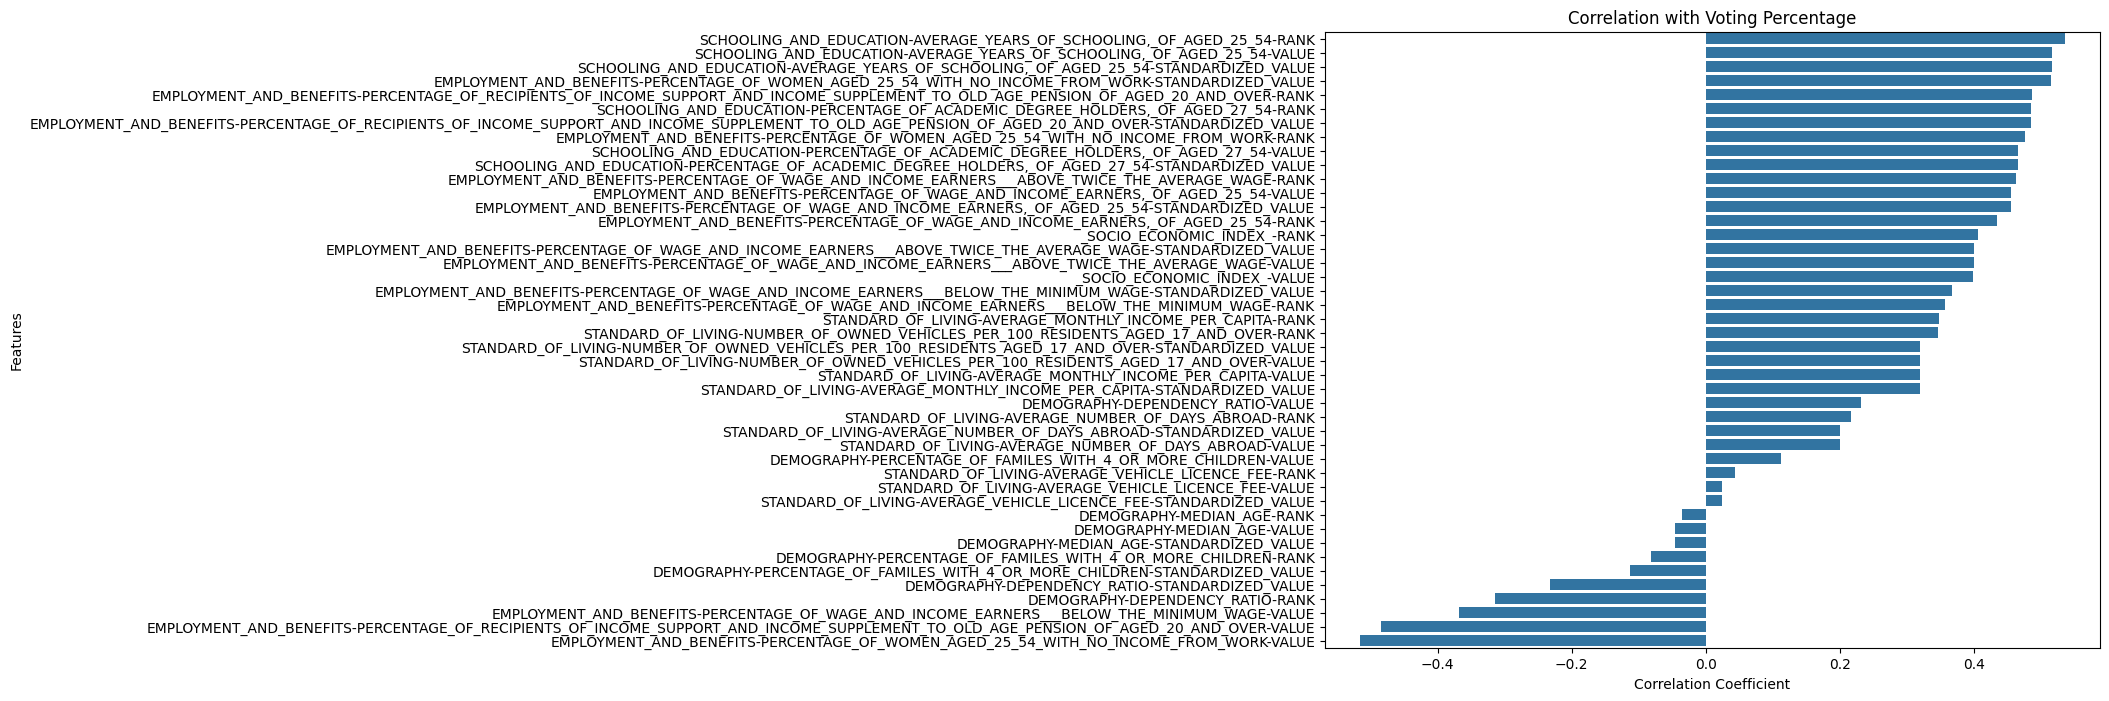

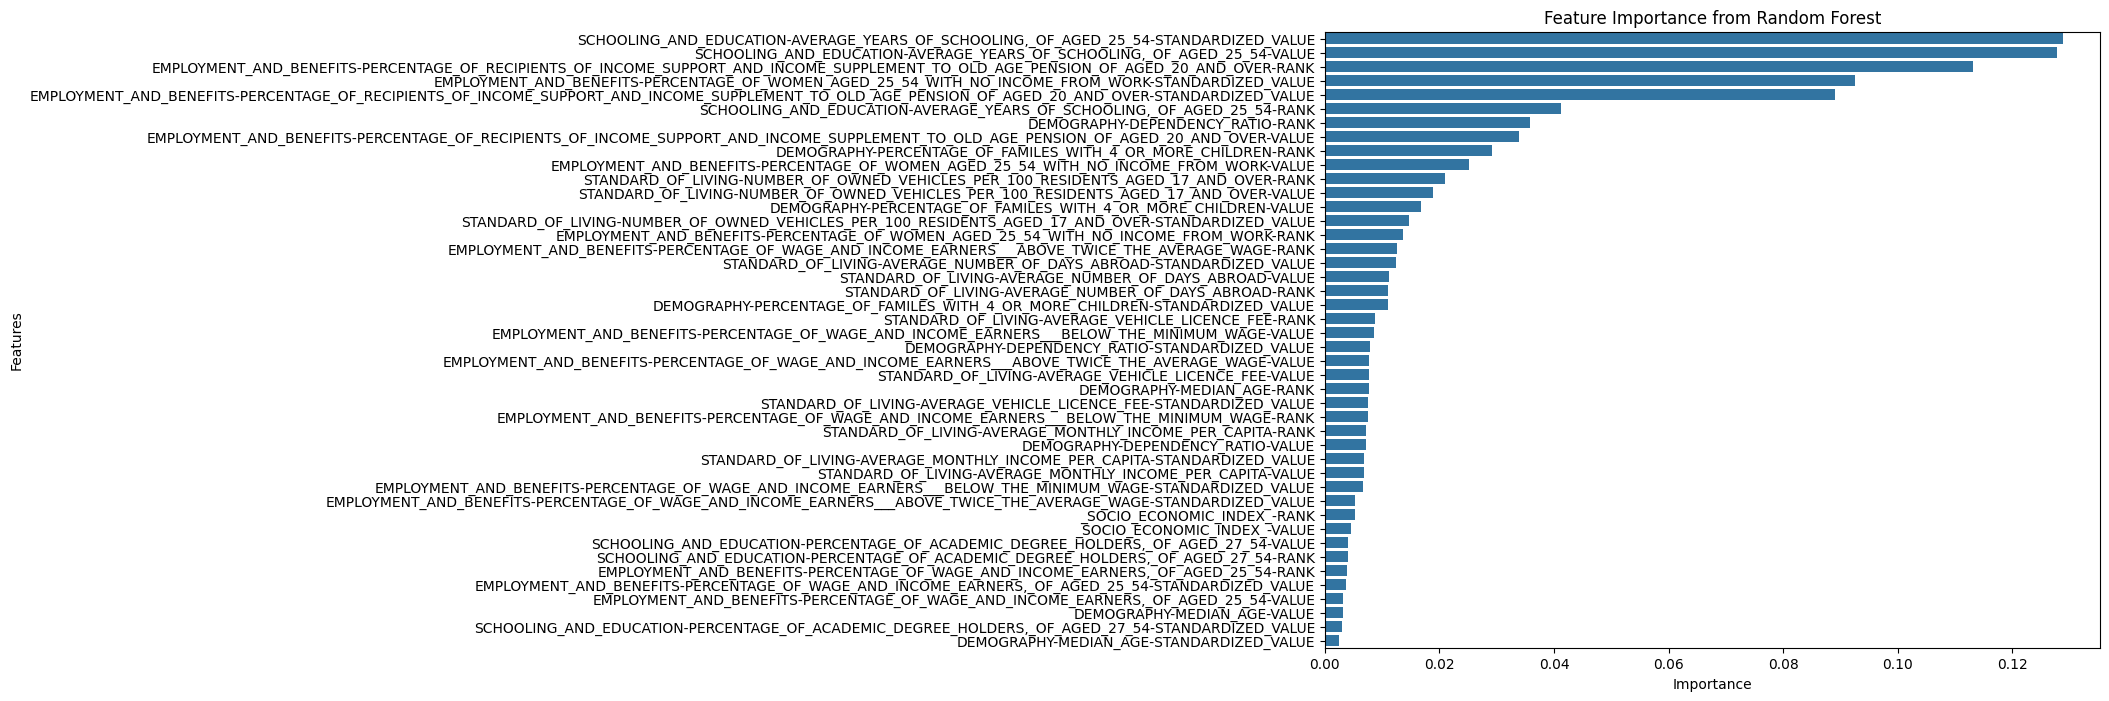

ANOVA F-test scores:
 SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-RANK                                                                                2362.040135
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-STANDARDIZED_VALUE                                                                  2144.027384
SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOOLING,_OF_AGED_25_54-VALUE                                                                               2144.027384
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WOMEN_AGED_25_54_WITH_NO_INCOME_FROM_WORK-VALUE                                                                 2125.880307
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WOMEN_AGED_25_54_WITH_NO_INCOME_FROM_WORK-STANDARDIZED_VALUE                                                    2125.880307
EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIENTS_OF_INCOME_SUPPORT_AND_INCOME_SUPPLEMENT_TO_OLD_AGE_PENSION_OF_AGED_20_AND_OVER-RANK                  1821.452136
SCHOOL

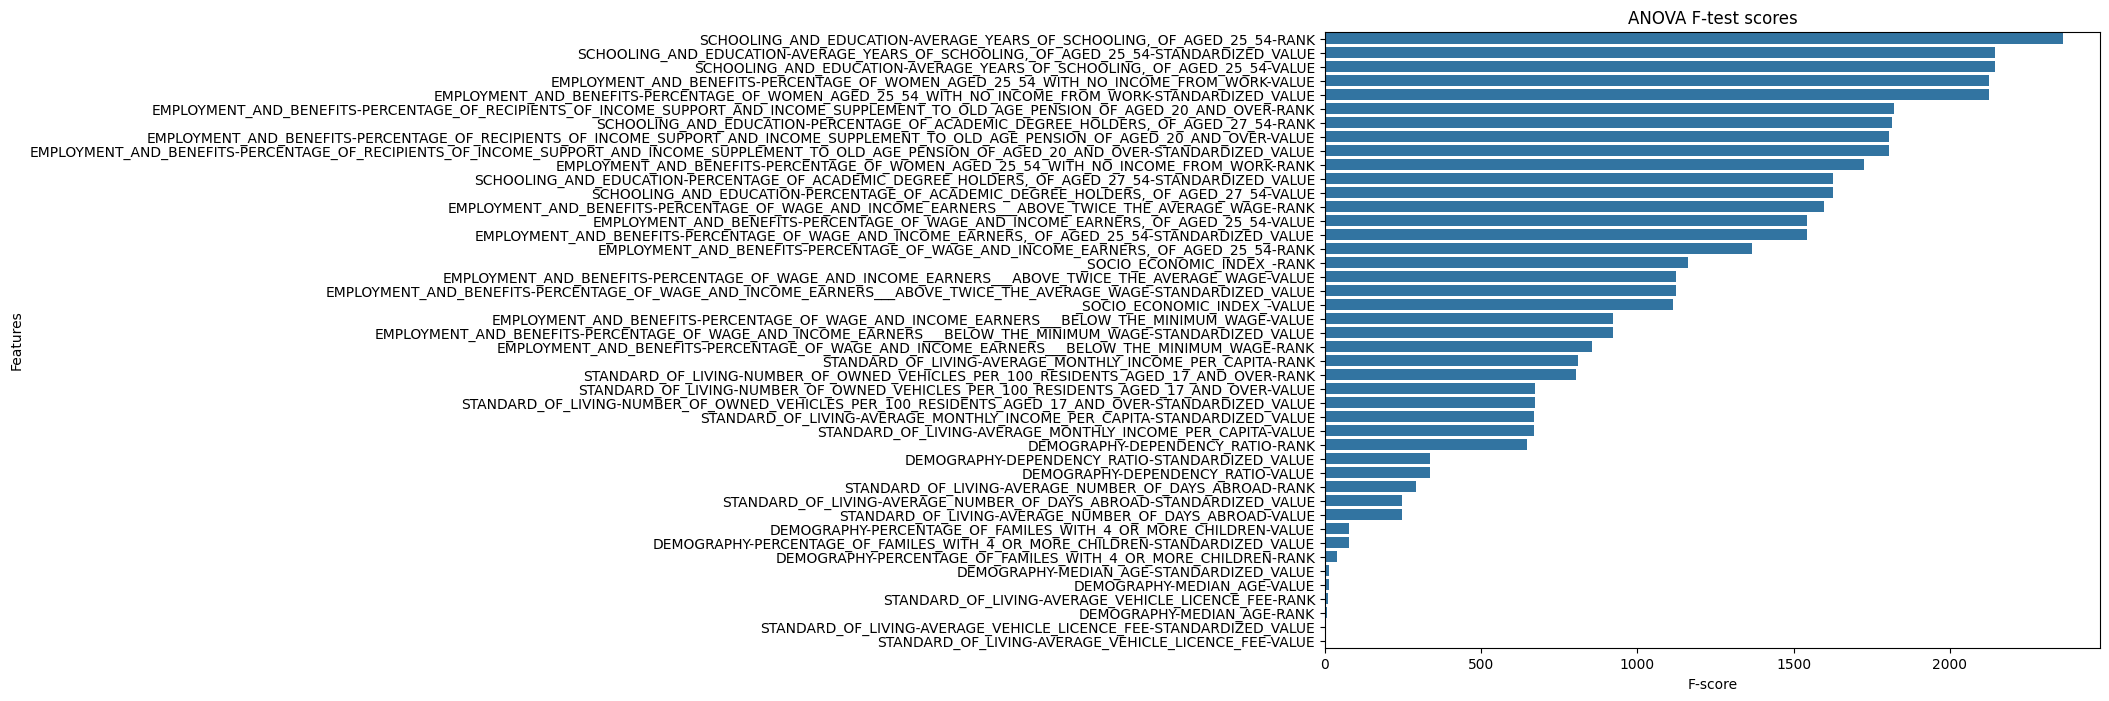

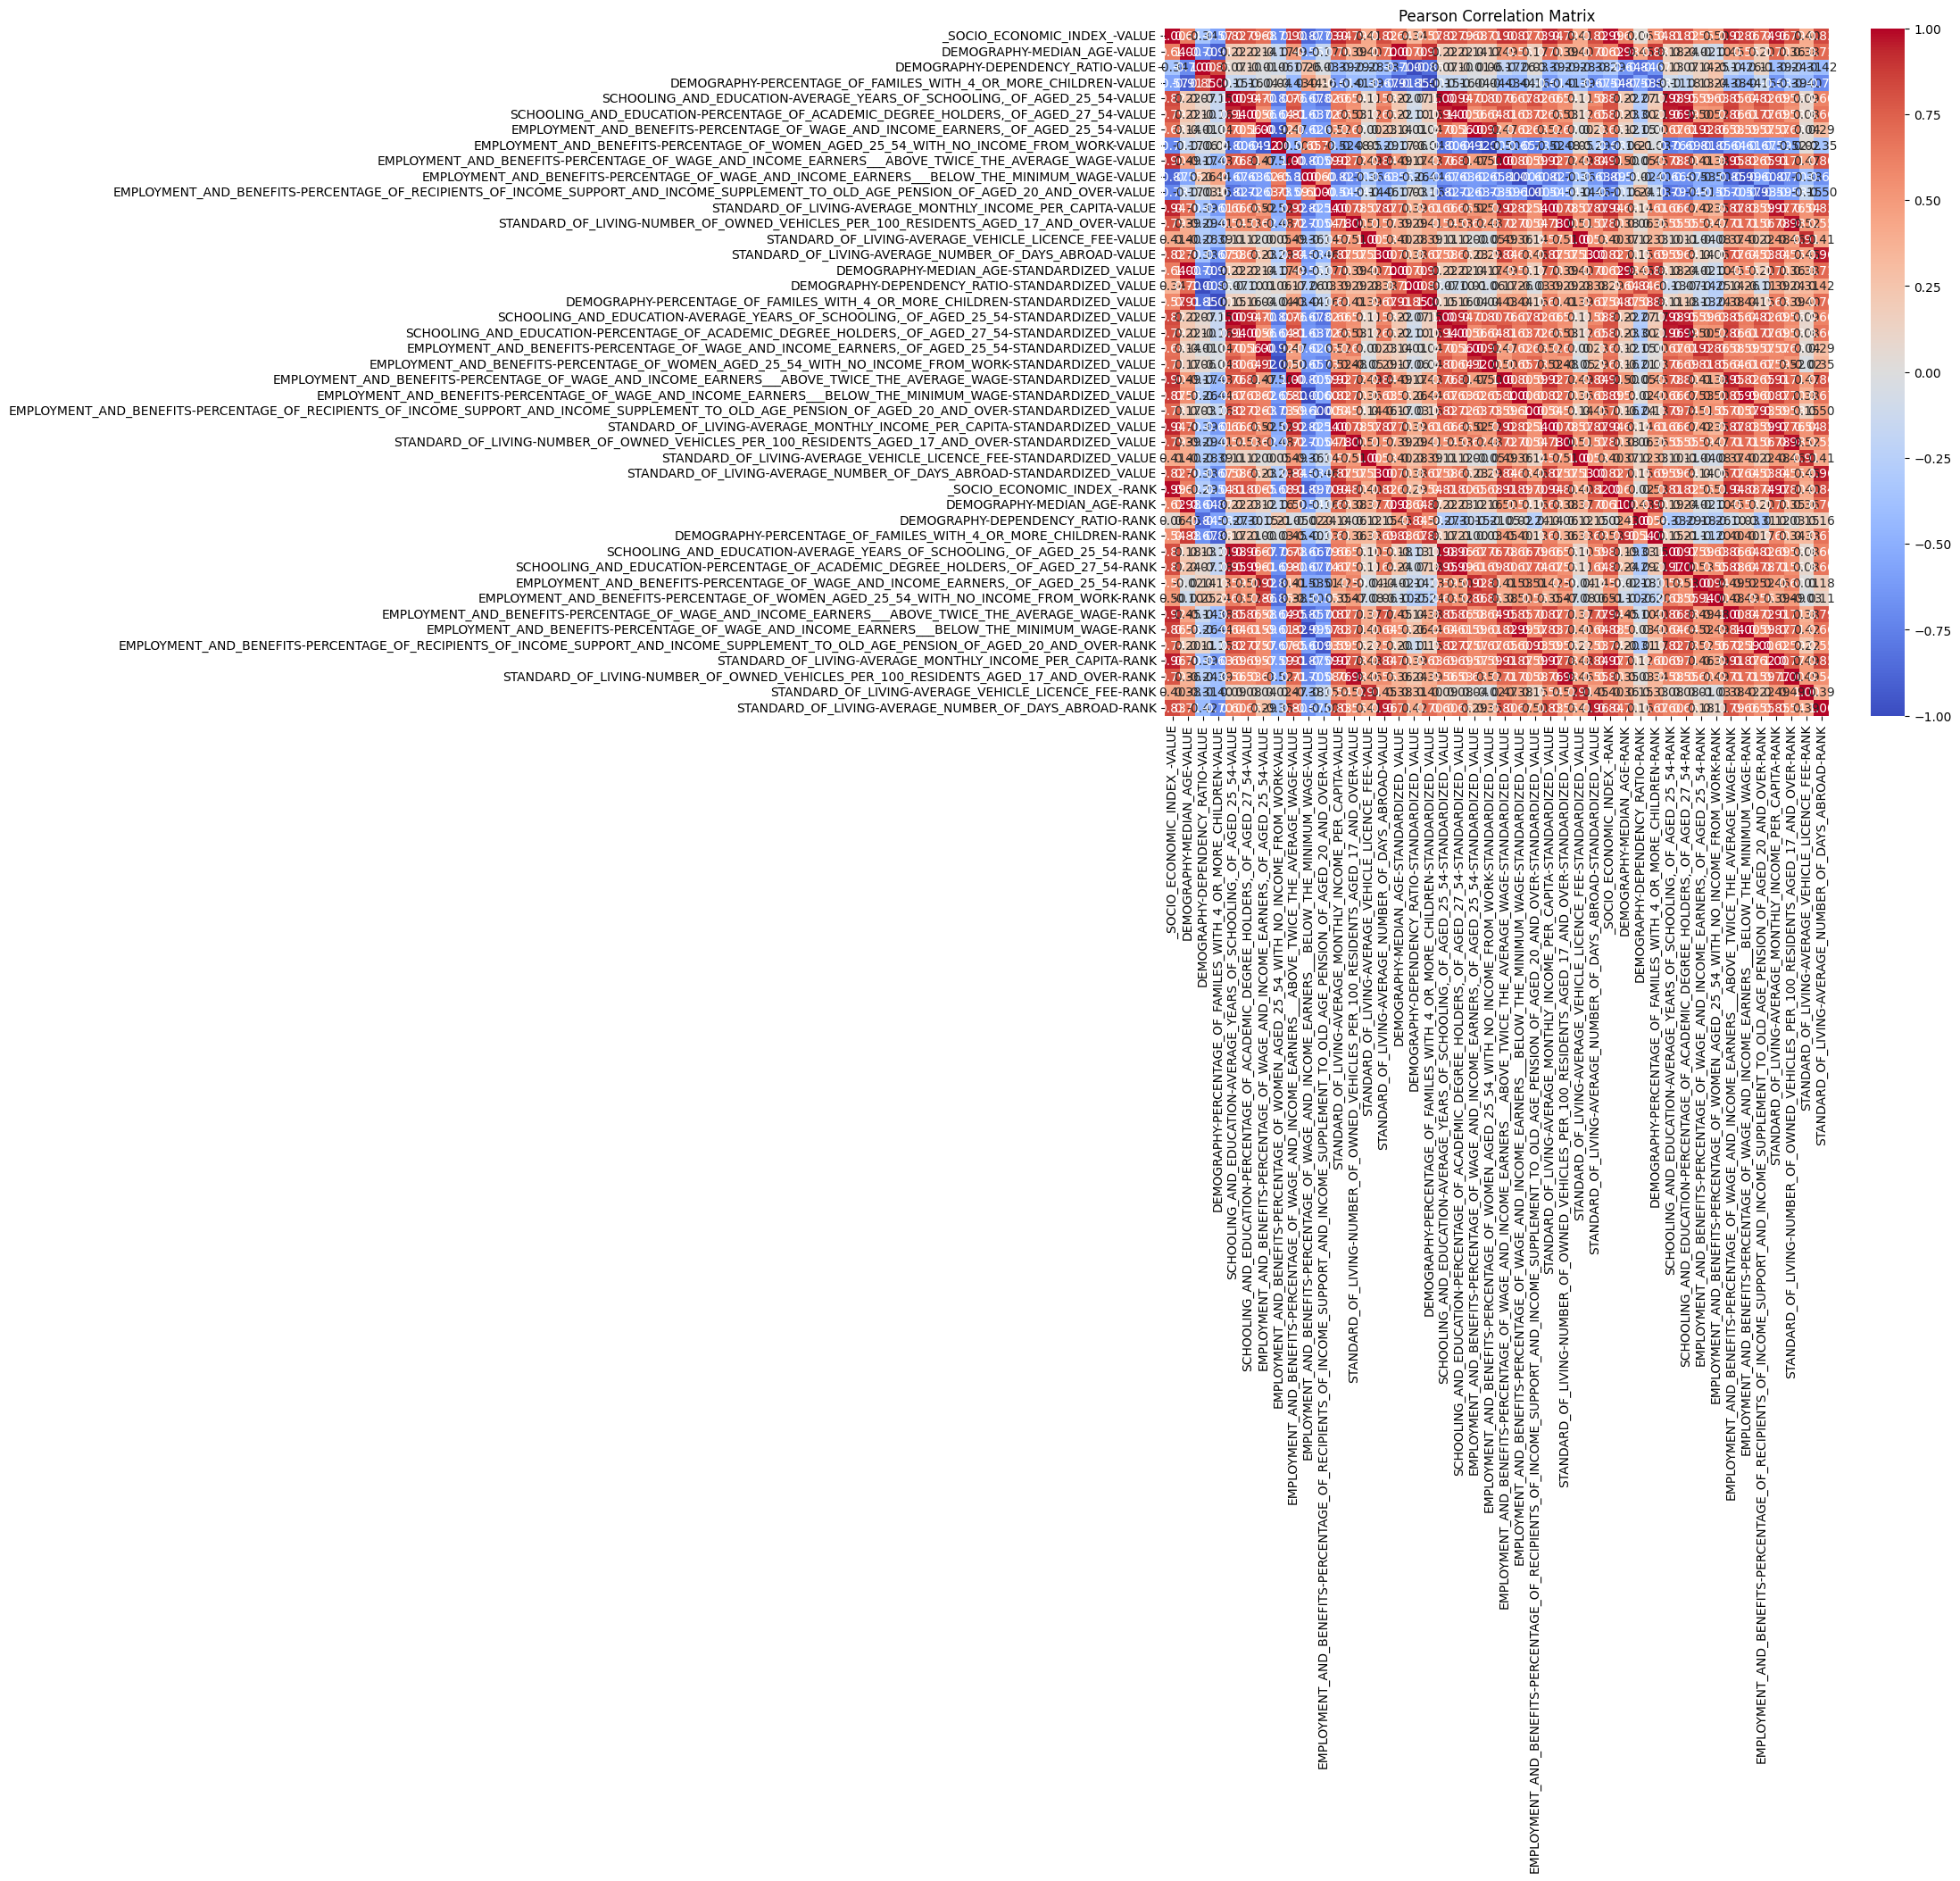

In [46]:
required_columns = value_columns + standardized_value_columns + rank_columns

# Prepare the data
X = data[required_columns]
y = data['Voting precantage']

# Compute correlation matrix
correlation_matrix = X.corrwith(y).sort_values(ascending=False)
print("Correlation with Voting Percentage:\n", correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.barplot(x=correlation_matrix.values, y=correlation_matrix.index)
plt.title('Correlation with Voting Percentage')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

# Feature importance using Random Forest
model = RandomForestRegressor()
model.fit(X, y)
feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

# ANOVA F-test scores
f_scores, p_values = f_regression(X, y)
f_scores_series = pd.Series(f_scores, index=X.columns).sort_values(ascending=False)
p_values_series = pd.Series(p_values, index=X.columns).sort_values(ascending=False)

print("ANOVA F-test scores:\n", f_scores_series)
print("p-values:\n", p_values_series)

# Plot ANOVA F-test scores
plt.figure(figsize=(10, 8))
sns.barplot(x=f_scores_series.values, y=f_scores_series.index)
plt.title('ANOVA F-test scores')
plt.xlabel('F-score')
plt.ylabel('Features')
plt.show()

# Calculate Pearson correlation matrix
correlation_matrix = X.corr(method='pearson')

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Matrix')
plt.show()



Function for evaluating models

In [47]:
def get_variable_name(var):
    name = [name for name in globals() if globals()[name] is var]
    return name[0].replace('_', ' ') if name else None

def evaluate_model(model, X_train, X_val, y_train, y_val):
    train_predictions = model.predict(X_train)
    val_predictions = model.predict(X_val)

    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    train_mae = mean_absolute_error(y_train, train_predictions)
    train_r2 = r2_score(y_train, train_predictions)
    train_adj_r2 = 1 - (1 - train_r2) * ((X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
    train_std = np.std(train_predictions - y_train)

    val_rmse = mean_squared_error(y_val, val_predictions, squared=False)
    val_mae = mean_absolute_error(y_val, val_predictions)
    val_r2 = r2_score(y_val, val_predictions)
    val_adj_r2 = 1 - (1 - val_r2) * ((X_val.shape[0] - 1) / (X_val.shape[0] - X_val.shape[1] - 1))
    val_std = np.std(val_predictions - y_val)

    model_name = get_variable_name(model)
    print(f"{model_name} Results:")
    print(f"Training Set RMSE: {train_rmse}")
    print(f"Training Set MAE: {train_mae}")
    print(f"Training Set R-squared: {train_r2}")
    print(f"Training Set Adjusted R-squared: {train_adj_r2}")
    print(f"Training Set Standard Deviation: {train_std}")
    print(f"Validation Set RMSE: {val_rmse}")
    print(f"Validation Set MAE: {val_mae}")
    print(f"Validation Set R-squared: {val_r2}")
    print(f"Validation Set Adjusted R-squared: {val_adj_r2}")
    print(f"Validation Set Standard Deviation: {val_std}")
    print("\n")


    return train_rmse, train_mae, train_r2, train_adj_r2, train_std, val_rmse, val_mae, val_r2, val_adj_r2, val_std

**Models**

In [48]:
X_value = data[value_columns]
X_standardized_value = data[standardized_value_columns]
X_rank = data[rank_columns]
y = data['Voting precantage']

X_value_train, X_value_val, y_train, y_val = train_test_split(X_value, y, test_size=0.2, random_state=42)
X_standardized_value_train, X_standardized_value_val, _, _ = train_test_split(X_standardized_value, y, test_size=0.2, random_state=42)
X_rank_train, X_rank_val, _, _ = train_test_split(X_rank, y, test_size=0.2, random_state=42)

Linear Regression

In [49]:
LR_model_value = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_value.fit(X_value_train, y_train)

LR_model_standardized_value = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_standardized_value.fit(X_standardized_value_train, y_train)

LR_model_rank = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

LR_model_rank.fit(X_rank_train, y_train)

train_rmse_value, train_mae_value, train_r2_value, train_adj_r2_value, train_std_value, val_rmse_value, val_mae_value, val_r2_value, val_adj_r2_value, val_std_value = evaluate_model(LR_model_value, X_value_train, X_value_val, y_train, y_val)
train_rmse_standardized_value, train_mae_standardized_value, train_r2_standardized_value, train_adj_r2_standardized_value, train_std_standardized_value, val_rmse_standardized_value, val_mae_standardized_value, val_r2_standardized_value, val_adj_r2_standardized_value, val_std_standardized_value = evaluate_model(LR_model_standardized_value, X_standardized_value_train, X_standardized_value_val, y_train, y_val)
train_rmse_rank, train_mae_rank, train_r2_rank, train_adj_r2_rank, train_std_rank, val_rmse_rank, val_mae_rank, val_r2_rank, val_adj_r2_rank, val_std_rank = evaluate_model(LR_model_rank, X_rank_train, X_rank_val, y_train, y_val)


LR model value Results:
Training Set RMSE: 0.08529457951848915
Training Set MAE: 0.05838258932273345
Training Set R-squared: 0.3792814102426453
Training Set Adjusted R-squared: 0.37729192758316654
Training Set Standard Deviation: 0.08529457951848915
Validation Set RMSE: 0.08014701266840638
Validation Set MAE: 0.05565126226466897
Validation Set R-squared: 0.3541665937064552
Validation Set Adjusted R-squared: 0.3458008760083523
Validation Set Standard Deviation: 0.08012207070979231


LR model standardized value Results:
Training Set RMSE: 0.08529499639037579
Training Set MAE: 0.058383344920482416
Training Set R-squared: 0.3792753427817732
Training Set Adjusted R-squared: 0.3774188708311099
Training Set Standard Deviation: 0.08529499639037579
Validation Set RMSE: 0.08014857257178995
Validation Set MAE: 0.0556558835116952
Validation Set R-squared: 0.35414145371717676
Validation Set Adjusted R-squared: 0.346339883701681
Validation Set Standard Deviation: 0.08012350542361434


LR model rank 

Decision Tree

In [50]:
# Define custom scoring functions for evaluation metrics
scoring = {
    'neg_root_mean_squared_error': make_scorer(mean_squared_error, greater_is_better=False, squared=False),
    'neg_mean_absolute_error': make_scorer(mean_absolute_error, greater_is_better=False),
    'r2': make_scorer(r2_score)
}

# Step 4: Train the Decision Tree Models
tree_model_value = DecisionTreeRegressor(random_state=42)
tree_model_standardized_value = DecisionTreeRegressor(random_state=42)
tree_model_rank = DecisionTreeRegressor(random_state=42)

# Perform cross-validation
cv_results_value = cross_validate(tree_model_value, X_value_train, y_train, scoring=scoring, cv=5, return_train_score=True)
cv_results_standardized_value = cross_validate(tree_model_standardized_value, X_standardized_value_train, y_train, scoring=scoring, cv=5, return_train_score=True)
cv_results_rank = cross_validate(tree_model_rank, X_rank_train, y_train, scoring=scoring, cv=5, return_train_score=True)

# Extract mean scores from cross-validation results
train_rmse_tree_value = -np.mean(cv_results_value['train_neg_root_mean_squared_error'])
train_mae_tree_value = -np.mean(cv_results_value['train_neg_mean_absolute_error'])
train_r2_tree_value = np.mean(cv_results_value['train_r2'])
val_rmse_tree_value = -np.mean(cv_results_value['test_neg_root_mean_squared_error'])
val_mae_tree_value = -np.mean(cv_results_value['test_neg_mean_absolute_error'])
val_r2_tree_value = np.mean(cv_results_value['test_r2'])

train_rmse_tree_standardized_value = -np.mean(cv_results_standardized_value['train_neg_root_mean_squared_error'])
train_mae_tree_standardized_value = -np.mean(cv_results_standardized_value['train_neg_mean_absolute_error'])
train_r2_tree_standardized_value = np.mean(cv_results_standardized_value['train_r2'])
val_rmse_tree_standardized_value = -np.mean(cv_results_standardized_value['test_neg_root_mean_squared_error'])
val_mae_tree_standardized_value = -np.mean(cv_results_standardized_value['test_neg_mean_absolute_error'])
val_r2_tree_standardized_value = np.mean(cv_results_standardized_value['test_r2'])

train_rmse_tree_rank = -np.mean(cv_results_rank['train_neg_root_mean_squared_error'])
train_mae_tree_rank = -np.mean(cv_results_rank['train_neg_mean_absolute_error'])
train_r2_tree_rank = np.mean(cv_results_rank['train_r2'])
val_rmse_tree_rank = -np.mean(cv_results_rank['test_neg_root_mean_squared_error'])
val_mae_tree_rank = -np.mean(cv_results_rank['test_neg_mean_absolute_error'])
val_r2_tree_rank = np.mean(cv_results_rank['test_r2'])

# Display Results
print("Decision Tree (VALUE) Results:")
print("Training Set RMSE:", train_rmse_tree_value)
print("Training Set MAE:", train_mae_tree_value)
print("Training Set R-squared:", train_r2_tree_value)
print("Validation Set RMSE:", val_rmse_tree_value)
print("Validation Set MAE:", val_mae_tree_value)
print("Validation Set R-squared:", val_r2_tree_value)

print("\nDecision Tree (STANDARDIZED_VALUE) Results:")
print("Training Set RMSE:", train_rmse_tree_standardized_value)
print("Training Set MAE:", train_mae_tree_standardized_value)
print("Training Set R-squared:", train_r2_tree_standardized_value)
print("Validation Set RMSE:", val_rmse_tree_standardized_value)
print("Validation Set MAE:", val_mae_tree_standardized_value)
print("Validation Set R-squared:", val_r2_tree_standardized_value)

print("\nDecision Tree (RANK) Results:")
print("Training Set RMSE:", train_rmse_tree_rank)
print("Training Set MAE:", train_mae_tree_rank)
print("Training Set R-squared:", train_r2_tree_rank)
print("Validation Set RMSE:", val_rmse_tree_rank)
print("Validation Set MAE:", val_mae_tree_rank)
print("Validation Set R-squared:", val_r2_tree_rank)


Decision Tree (VALUE) Results:
Training Set RMSE: 0.07432104925020089
Training Set MAE: 0.050210202351109776
Training Set R-squared: 0.5286681943766409
Validation Set RMSE: 0.07947024053012562
Validation Set MAE: 0.053989748553190386
Validation Set R-squared: 0.4602860160934815

Decision Tree (STANDARDIZED_VALUE) Results:
Training Set RMSE: 0.07446900528596571
Training Set MAE: 0.050364838949862135
Training Set R-squared: 0.5267907577555151
Validation Set RMSE: 0.07961430262673959
Validation Set MAE: 0.05414935958503947
Validation Set R-squared: 0.4583299761146595

Decision Tree (RANK) Results:
Training Set RMSE: 0.07432104925020087
Training Set MAE: 0.050210202351109776
Training Set R-squared: 0.528668194376641
Validation Set RMSE: 0.07954876194561547
Validation Set MAE: 0.05401245378510302
Validation Set R-squared: 0.4591410310205822


In [51]:
forest_model_value = RandomForestRegressor(random_state=42)
forest_model_value.fit(X_value_train, y_train)

forest_model_standardized_value = RandomForestRegressor(random_state=42)
forest_model_standardized_value.fit(X_standardized_value_train, y_train)

forest_model_rank = RandomForestRegressor(random_state=42)
forest_model_rank.fit(X_rank_train, y_train)

# Step 5: Evaluate the Random Forest Models
train_rmse_forest_value, train_mae_forest_value, train_r2_forest_value, _, train_std_forest_value, val_rmse_forest_value, val_mae_forest_value, val_r2_forest_value, _, val_std_forest_value = evaluate_model(forest_model_value, X_value_train, X_value_val, y_train, y_val)
train_rmse_forest_standardized_value, train_mae_forest_standardized_value, train_r2_forest_standardized_value, _, train_std_forest_standardized_value, val_rmse_forest_standardized_value, val_mae_forest_standardized_value, val_r2_forest_standardized_value, _, val_std_forest_standardized_value = evaluate_model(forest_model_standardized_value, X_standardized_value_train, X_standardized_value_val, y_train, y_val)
train_rmse_forest_rank, train_mae_forest_rank, train_r2_forest_rank, _, train_std_forest_rank,val_rmse_forest_rank, val_mae_forest_rank, val_r2_forest_rank, _, val_std_forest_rank = evaluate_model(forest_model_rank, X_rank_train, X_rank_val, y_train, y_val)

forest model value Results:
Training Set RMSE: 0.07480666163042245
Training Set MAE: 0.050633804425872654
Training Set R-squared: 0.5225450115980823
Training Set Adjusted R-squared: 0.5210147071480762
Training Set Standard Deviation: 0.07480666158927239
Validation Set RMSE: 0.07390474353959829
Validation Set MAE: 0.05013862797212369
Validation Set R-squared: 0.45085067373056387
Validation Set Adjusted R-squared: 0.4437373404887318
Validation Set Standard Deviation: 0.07389147808566013


forest model standardized value Results:
Training Set RMSE: 0.07495426986939366
Training Set MAE: 0.050788145597459436
Training Set R-squared: 0.5206589276512511
Training Set Adjusted R-squared: 0.5192253076954976
Training Set Standard Deviation: 0.07495426879359732
Validation Set RMSE: 0.07386538312928267
Validation Set MAE: 0.050111212003429016
Validation Set R-squared: 0.4514354531628233
Validation Set Adjusted R-squared: 0.44480913421914725
Validation Set Standard Deviation: 0.07385352148741094


fo

compare models

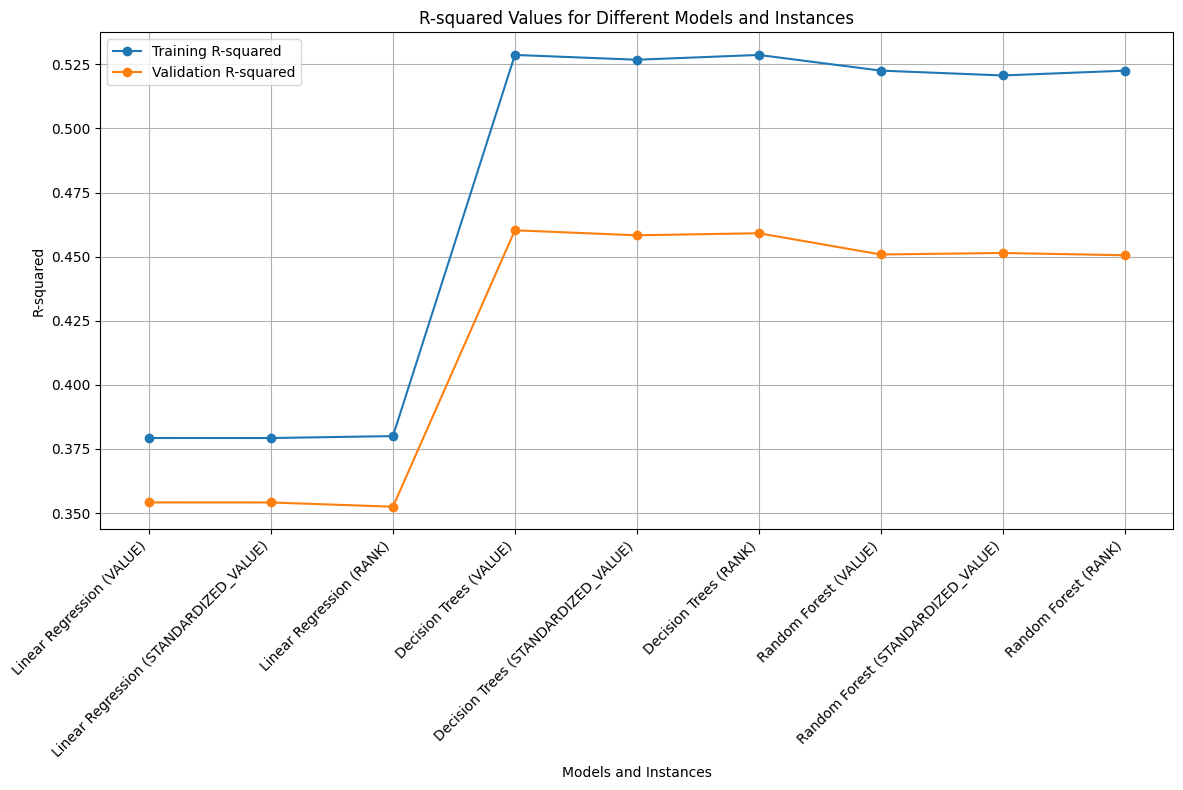

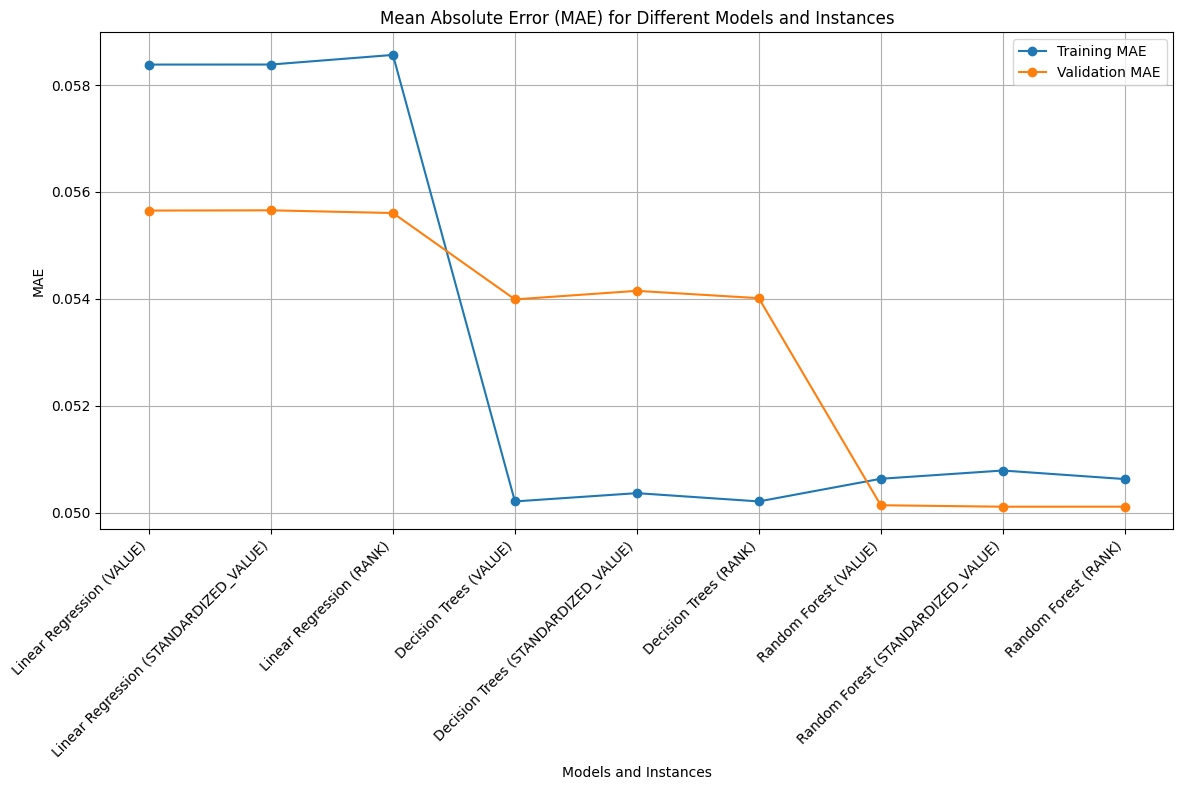

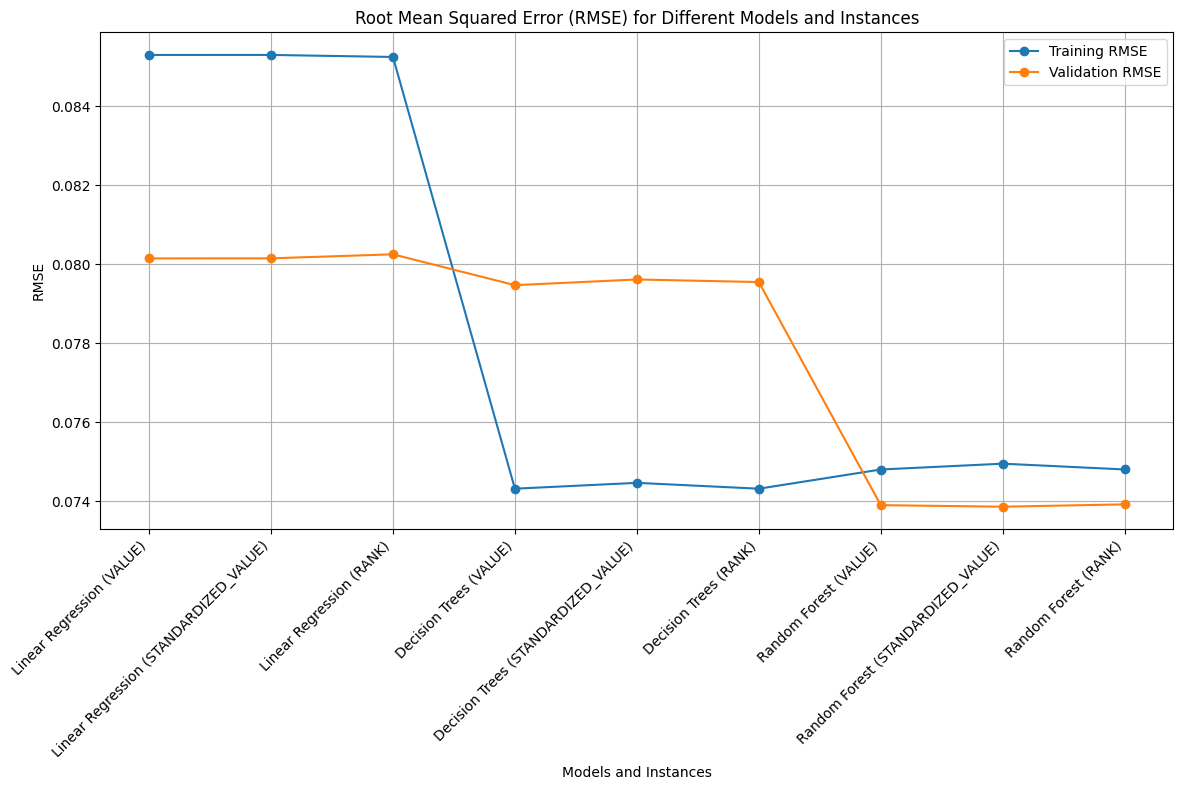

In [52]:
# Define model names and their corresponding R-squared values
models = ['Linear Regression (VALUE)', 'Linear Regression (STANDARDIZED_VALUE)', 'Linear Regression (RANK)', 'Decision Trees (VALUE)', 'Decision Trees (STANDARDIZED_VALUE)', 'Decision Trees (RANK)',
          'Random Forest (VALUE)', 'Random Forest (STANDARDIZED_VALUE)', 'Random Forest (RANK)']
train_r2_values = [train_r2_value, train_r2_standardized_value, train_r2_rank, train_r2_tree_value, train_r2_tree_standardized_value, train_r2_tree_rank,
                   train_r2_forest_value, train_r2_forest_standardized_value, train_r2_forest_rank]
val_r2_values = [val_r2_value, val_r2_standardized_value, val_r2_rank, val_r2_tree_value, val_r2_tree_standardized_value, val_r2_tree_rank,
                 val_r2_forest_value, val_r2_forest_standardized_value, val_r2_forest_rank]

# Plotting R-squared values for both training and validation sets
plt.figure(figsize=(12, 8))
plt.plot(models, train_r2_values, marker='o', label='Training R-squared')
plt.plot(models, val_r2_values, marker='o', label='Validation R-squared')
plt.title('R-squared Values for Different Models and Instances')
plt.xlabel('Models and Instances')
plt.ylabel('R-squared')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('R-squared Values for Different Models and Instances.png')
plt.show()

# Define MAE values for training and validation sets
train_mae_values = [train_mae_value, train_mae_standardized_value, train_mae_rank, train_mae_tree_value, train_mae_tree_standardized_value, train_mae_tree_rank,
                    train_mae_forest_value, train_mae_forest_standardized_value, train_mae_forest_rank]
val_mae_values = [val_mae_value, val_mae_standardized_value, val_mae_rank, val_mae_tree_value, val_mae_tree_standardized_value, val_mae_tree_rank,
                  val_mae_forest_value, val_mae_forest_standardized_value, val_mae_forest_rank]

# Define RMSE values for training and validation sets
train_rmse_values = [train_rmse_value, train_rmse_standardized_value, train_rmse_rank, train_rmse_tree_value, train_rmse_tree_standardized_value, train_rmse_tree_rank,
                     train_rmse_forest_value, train_rmse_forest_standardized_value, train_rmse_forest_rank]
val_rmse_values = [val_rmse_value, val_rmse_standardized_value, val_rmse_rank, val_rmse_tree_value, val_rmse_tree_standardized_value, val_rmse_tree_rank,
                   val_rmse_forest_value, val_rmse_forest_standardized_value, val_rmse_forest_rank]

# Plotting MAE values for both training and validation sets
plt.figure(figsize=(12, 8))
plt.plot(models, train_mae_values, marker='o', label='Training MAE')
plt.plot(models, val_mae_values, marker='o', label='Validation MAE')
plt.title('Mean Absolute Error (MAE) for Different Models and Instances')
plt.xlabel('Models and Instances')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Mean Absolute Error (MAE) for Different Models and Instances.png')
plt.show()

# Plotting RMSE values for both training and validation sets
plt.figure(figsize=(12, 8))
plt.plot(models, train_rmse_values, marker='o', label='Training RMSE')
plt.plot(models, val_rmse_values, marker='o', label='Validation RMSE')
plt.title('Root Mean Squared Error (RMSE) for Different Models and Instances')
plt.xlabel('Models and Instances')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('Root Mean Squared Error (RMSE) for  Different Models and Instances.png')
plt.show()


best model

In [53]:
# Create a dictionary to store model names and their corresponding evaluation metrics
model_metrics = {
    'Model': models,
    'Train_RMSE': train_rmse_values,
    'Val_RMSE': val_rmse_values,
    'Train_MAE': train_mae_values,
    'Val_MAE': val_mae_values,
    'Train_R2': train_r2_values,
    'Val_R2': val_r2_values
}

# Convert the dictionary to a DataFrame for easier manipulation and visualization
metrics_df = pd.DataFrame(model_metrics)

# Sort the DataFrame by the desired metric (e.g., Val_RMSE)
sorted_metrics_df = metrics_df.sort_values(by='Val_RMSE', ascending=True)

# Display the sorted DataFrame
print(sorted_metrics_df)

# Based on the sorted DataFrame, choose the best model considering multiple metrics
best_model_index = sorted_metrics_df['Val_RMSE'].idxmin()
best_model_name = sorted_metrics_df.loc[best_model_index, 'Model']

print(f"\nThe best model based on minimal validation RMSE is: {best_model_name}")

                                    Model  Train_RMSE  Val_RMSE  Train_MAE  \
7      Random Forest (STANDARDIZED_VALUE)    0.074954  0.073865   0.050788   
6                   Random Forest (VALUE)    0.074807  0.073905   0.050634   
8                    Random Forest (RANK)    0.074808  0.073925   0.050628   
3                  Decision Trees (VALUE)    0.074321  0.079470   0.050210   
5                   Decision Trees (RANK)    0.074321  0.079549   0.050210   
4     Decision Trees (STANDARDIZED_VALUE)    0.074469  0.079614   0.050365   
0               Linear Regression (VALUE)    0.085295  0.080147   0.058383   
1  Linear Regression (STANDARDIZED_VALUE)    0.085295  0.080149   0.058383   
2                Linear Regression (RANK)    0.085243  0.080251   0.058563   

    Val_MAE  Train_R2    Val_R2  
7  0.050111  0.520659  0.451435  
6  0.050139  0.522545  0.450851  
8  0.050111  0.522529  0.450550  
3  0.053990  0.528668  0.460286  
5  0.054012  0.528668  0.459141  
4  0.054149  0.

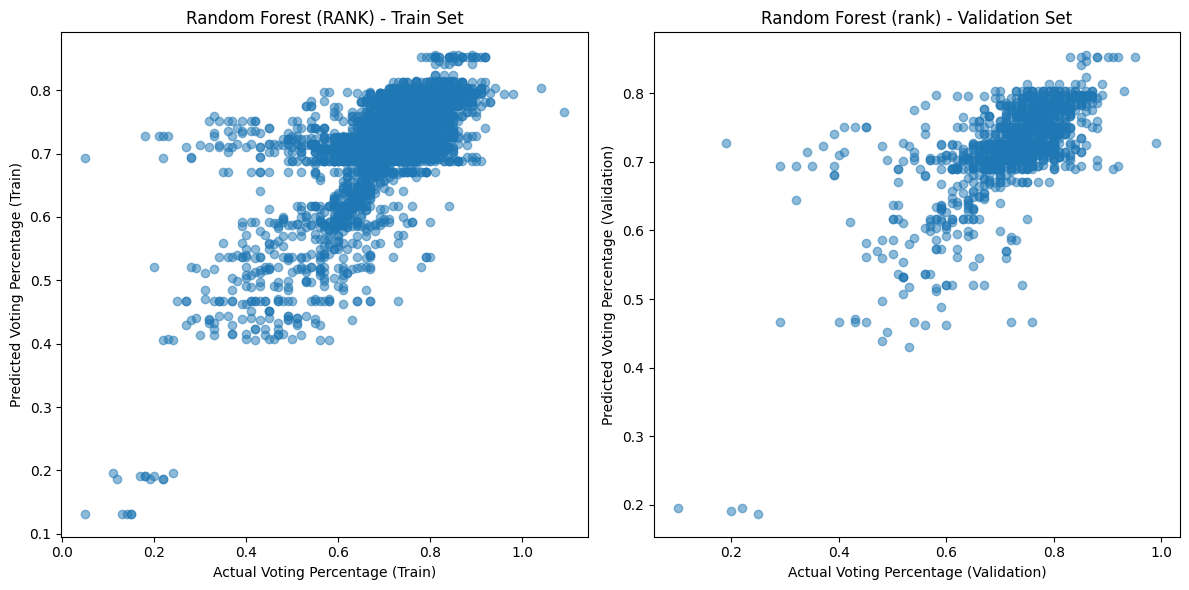

In [64]:
# Predictions on training and validation sets
train_predictions_forest_rank = forest_model_rank.predict(X_rank_train)
val_predictions_forest_rank = forest_model_rank.predict(X_rank_val)

# Scatter plots for predicted vs actual values
plt.figure(figsize=(12, 6))

# Training set plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, train_predictions_forest_rank, alpha=0.5)
plt.xlabel('Actual Voting Percentage (Train)')
plt.ylabel('Predicted Voting Percentage (Train)')
plt.title('Random Forest (RANK) - Train Set')

# Validation set plot
plt.subplot(1, 2, 2)
plt.scatter(y_val, val_predictions_forest_rank, alpha=0.5)
plt.xlabel('Actual Voting Percentage (Validation)')
plt.ylabel('Predicted Voting Percentage (Validation)')
plt.title('Random Forest (rank) - Validation Set')

plt.tight_layout()
plt.show()

**Test the Model**

In [65]:
all_columns = test.columns
all_columns = [col for col in all_columns if not col.startswith('_SOCIO_ECONOMIC_INDEX')]
value_columns = [col for col in all_columns if col.endswith('-VALUE')]
standardized_value_columns = [col for col in all_columns if col.endswith('-STANDARDIZED_VALUE')]
rank_columns = [col for col in all_columns if col.endswith('-RANK')]

X_rank = test[rank_columns]
X_rank_test = test[rank_columns]

predictions = forest_model_rank.predict(X_rank_test)


predictions_data = test.copy()
predictions_data['Predicted Voting Percentage'] = predictions

# Save the predictions to an Excel file
predictions_data.to_excel('predictions.xlsx')

In [66]:
# Extract actual and predicted values
y_true = predictions_data['Voting precantage']
y_pred = predictions_data['Predicted Voting Percentage']

# Calculate evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
std_residuals = np.std(y_pred - y_true)
# Print the evaluation metrics
print("Random Forest (RANK) - Localities:")
print("Train RMSE:", round(train_rmse_forest_rank, 3))
print("Test RMSE:", round(rmse, 3))
print("Train MAE:", round(train_mae_forest_rank, 3))
print("Test MAE:", round(mae, 3))
print("Train R-squared:", round(train_r2_forest_rank, 3))
print("Test R-squared:", round(r2, 3))
print("Train Standard Deviation of Residuals:", round(train_std_forest_rank, 3))
print("Test Standard Deviation of Residuals:", round(std_residuals, 3))

Mean Absolute Error: 0.048
Mean Squared Error: 0.006
R-squared: 0.465
Root Mean Squared Error: 0.074
Standard Deviation of Residuals: 0.072


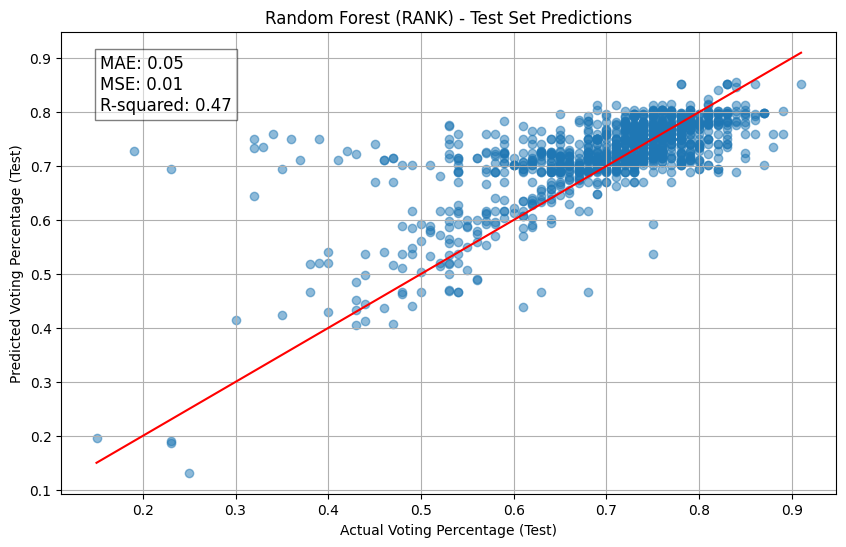

In [67]:
# Scatter plot for predicted vs actual values on test data
plt.figure(figsize=(10, 6))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red')  # Diagonal line
plt.xlabel('Actual Voting Percentage (Test)')
plt.ylabel('Predicted Voting Percentage (Test)')
# Display metrics as text on the plot
plt.text(0.05, 0.95, f'MAE: {mae:.2f}\nMSE: {mse:.2f}\nR-squared: {r2:.2f}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
plt.title('Random Forest (RANK) - Test Set Predictions')
plt.grid(True)
plt.show()

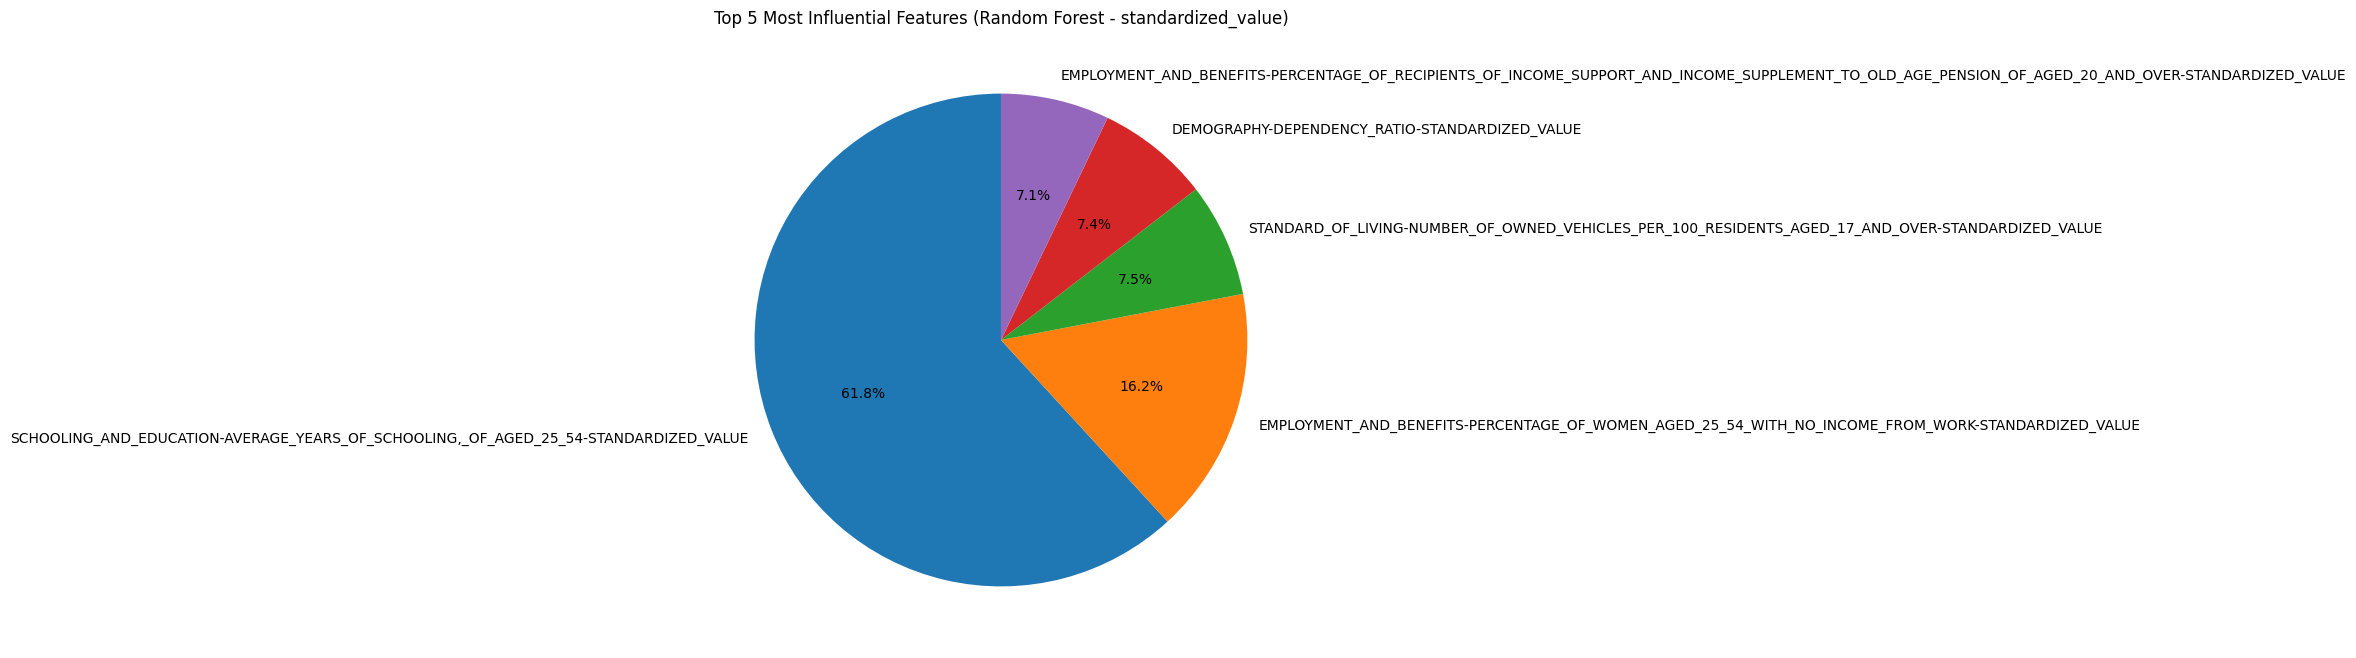

In [58]:
# Get feature importances
importances = forest_model_rank.feature_importances_

# Get feature names
feature_names = X_rank_train.columns

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select the top 5 features
top_5_features = feature_importances_df.head(5)

# Plot the top 5 features as a pie chart
plt.figure(figsize=(8, 8))
plt.pie(top_5_features['Importance'], labels=top_5_features['Feature'], autopct='%1.1f%%', startangle=90)
plt.title('Top 5 Most Influential Features (Random Forest - rank)')
plt.show()


<ipython-input-59-66790dac0254>:34: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.5 - 0.1*(5-i), y), 0.2*(5-i), 0.2, color=color, edgecolor='black')


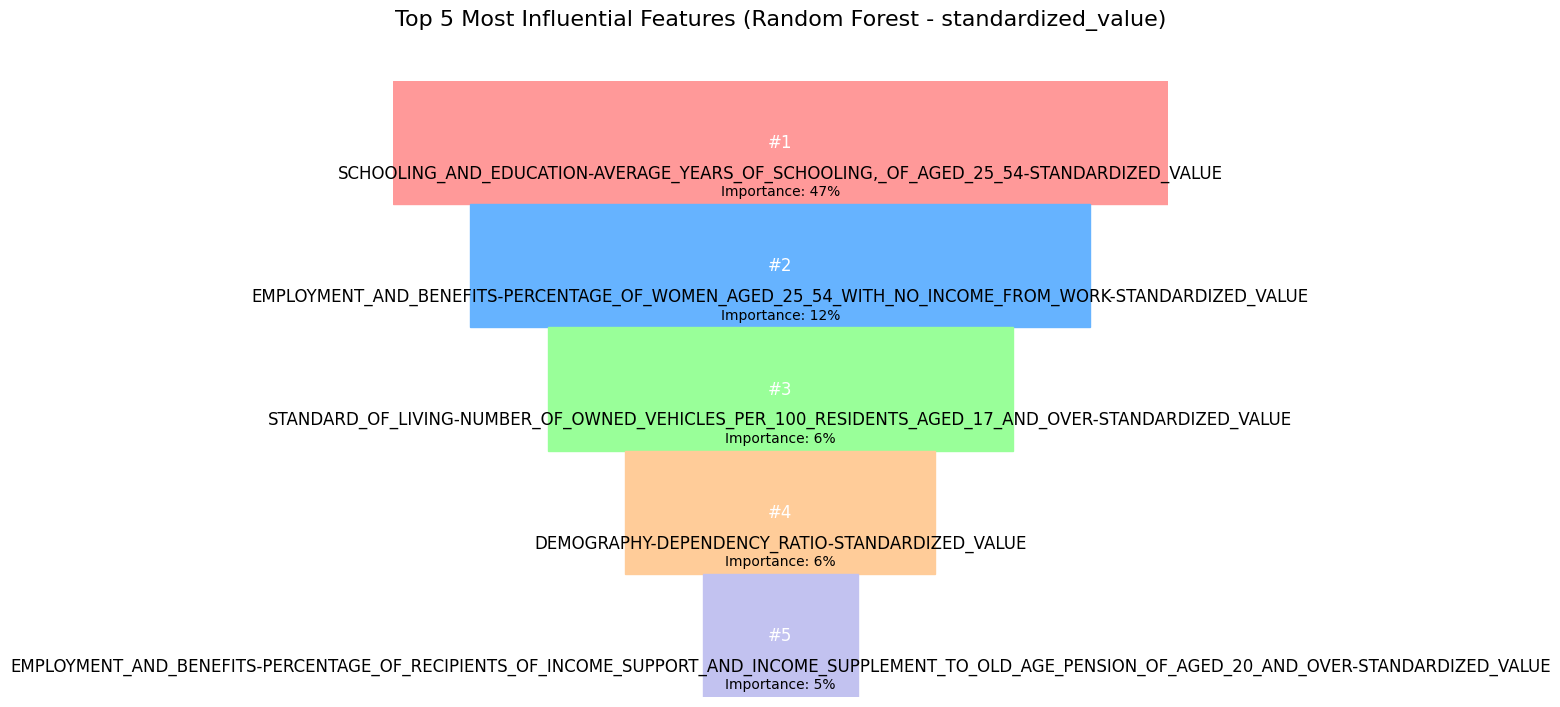

<ipython-input-59-66790dac0254>:66: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  rect = Rectangle((0.5 - 0.1*(3-i), y), 0.2*(3-i), 0.2, color=color, edgecolor='black')


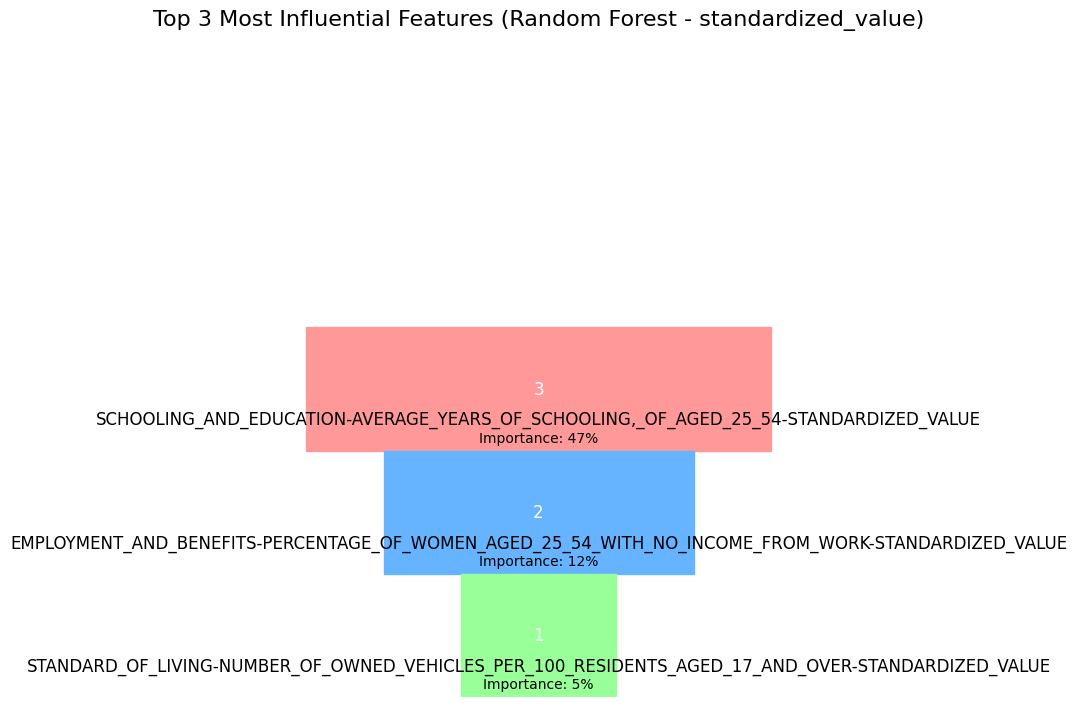

In [59]:

# Get feature importances from the trained Random Forest model
importances = forest_model_rank.feature_importances_

# Get feature names from the DataFrame
feature_names = X_rank.columns

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select the top 5 features
top_5_features = feature_importances_df.head(5)

# Extract feature names and importance values
features = top_5_features['Feature'].tolist()
importances = top_5_features['Importance'].tolist()

# Create a pyramid plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')  # Turn off the axis

# Define the pyramid layers
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','#c2c2f0']
y_positions = [0.8, 0.6, 0.4, 0.2, 0.0]

# Plot each layer
for i, (feature, importance, color, y) in enumerate(zip(features, importances, colors, y_positions)):
    rect = Rectangle((0.5 - 0.1*(5-i), y), 0.2*(5-i), 0.2, color=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(0.5, y + 0.1, f'#{i+1}', fontsize=12, ha='center', va='center', color='white')
    ax.text(0.5, y + 0.05, feature, fontsize=12, ha='center', va='center', color='black')
    ax.text(0.5, y + 0.02, f'Importance: {int(round(importance * 100))}%', fontsize=10, ha='center', va='center', color='black')

# Set plot title with more padding
plt.title('Top 5 Most Influential Features (Random Forest - rank)', fontsize=16, pad=40)

# Show the plot
plt.show()

# Select the top 3 features
top_3_features = feature_importances_df.head(3)

# Extract feature names and importance values
features = top_3_features['Feature'].tolist()
importances = top_3_features['Importance'].tolist()

# Convert importances to percentages and then to integers
importances = [int(imp * 100) for imp in importances]

# Create a pyramid plot
fig, ax = plt.subplots(figsize=(10, 8))
ax.axis('off')  # Turn off the axis

# Define the pyramid layers
colors = ['#ff9999','#66b3ff','#99ff99']
y_positions = [0.4, 0.2, 0.0]

# Plot each layer
for i, (feature, importance, color, y) in enumerate(zip(features, importances, colors, y_positions)):
    rect = Rectangle((0.5 - 0.1*(3-i), y), 0.2*(3-i), 0.2, color=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(0.5, y + 0.1, f'{3-i}', fontsize=12, ha='center', va='center', color='white')
    ax.text(0.5, y + 0.05, feature, fontsize=12, ha='center', va='center', color='black')
    ax.text(0.5, y + 0.02, f'Importance: {importance}%', fontsize=10, ha='center', va='center', color='black')

# Set plot title with more padding
plt.title('Top 3 Most Influential Features (Random Forest - rank)', fontsize=16, pad=40)

# Show the plot
plt.show()



In [60]:
# Get feature importances from the trained Random Forest model
importances = forest_model_rank.feature_importances_

# Get feature names from the DataFrame
feature_names = X_rank.columns

# Create a DataFrame to store feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the DataFrame by importance in descending order
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Print the feature importances
print(feature_importances_df)


                                              Feature  Importance
3   SCHOOLING_AND_EDUCATION-AVERAGE_YEARS_OF_SCHOO...    0.471188
6   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WOMEN_AG...    0.123375
11  STANDARD_OF_LIVING-NUMBER_OF_OWNED_VEHICLES_PE...    0.057000
1      DEMOGRAPHY-DEPENDENCY_RATIO-STANDARDIZED_VALUE    0.056442
9   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_RECIPIEN...    0.054297
13  STANDARD_OF_LIVING-AVERAGE_NUMBER_OF_DAYS_ABRO...    0.051412
2   DEMOGRAPHY-PERCENTAGE_OF_FAMILES_WITH_4_OR_MOR...    0.040391
12  STANDARD_OF_LIVING-AVERAGE_VEHICLE_LICENCE_FEE...    0.032359
8   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...    0.027805
7   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...    0.027248
0            DEMOGRAPHY-MEDIAN_AGE-STANDARDIZED_VALUE    0.018302
10  STANDARD_OF_LIVING-AVERAGE_MONTHLY_INCOME_PER_...    0.017073
4   SCHOOLING_AND_EDUCATION-PERCENTAGE_OF_ACADEMIC...    0.011833
5   EMPLOYMENT_AND_BENEFITS-PERCENTAGE_OF_WAGE_AND...    0.011276


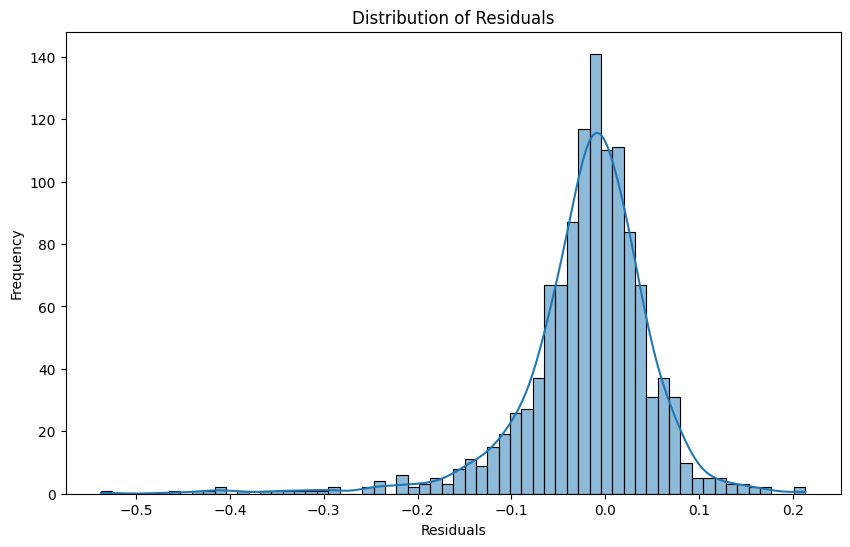

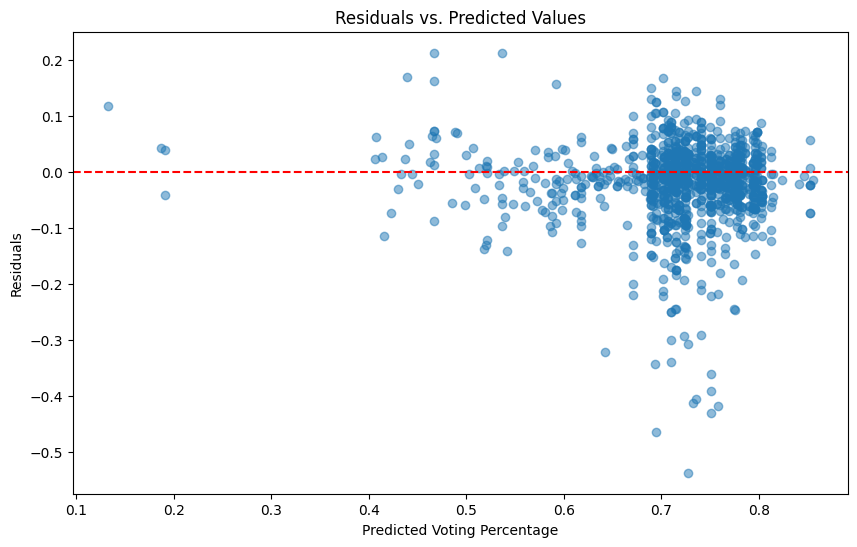

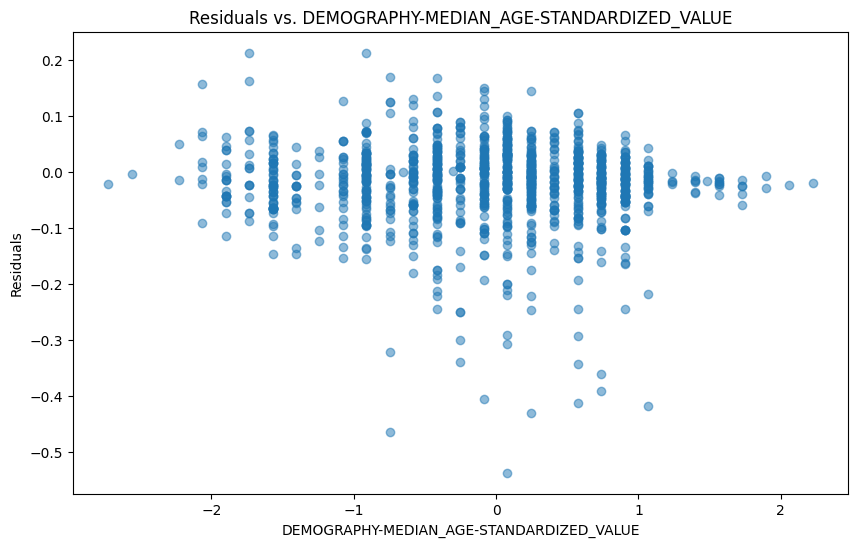

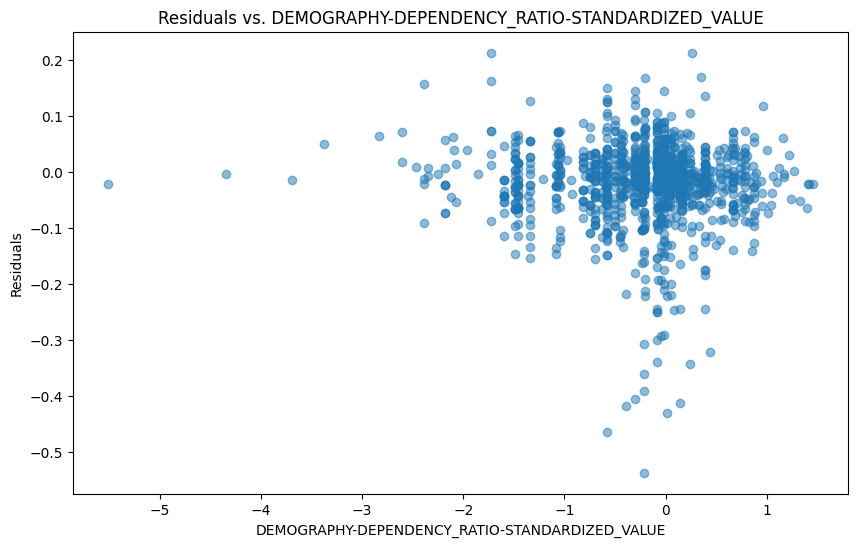

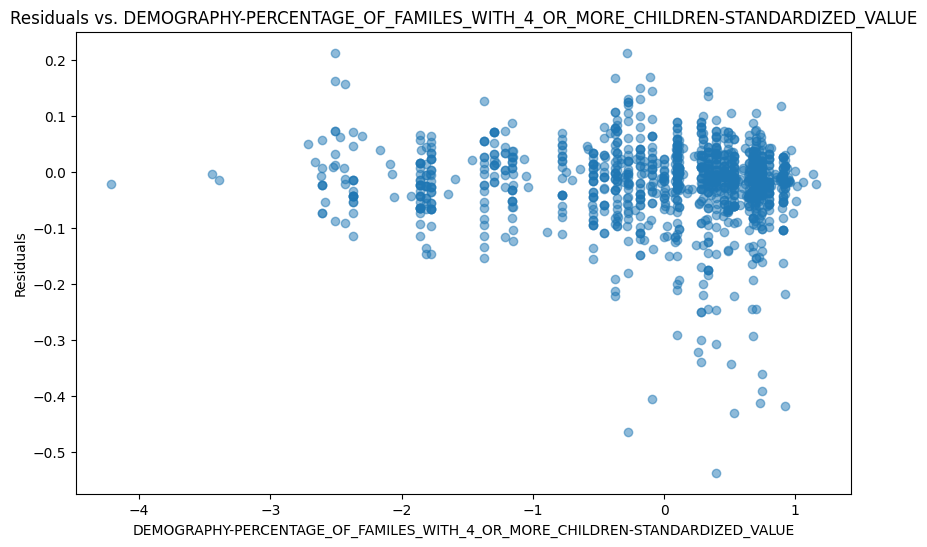

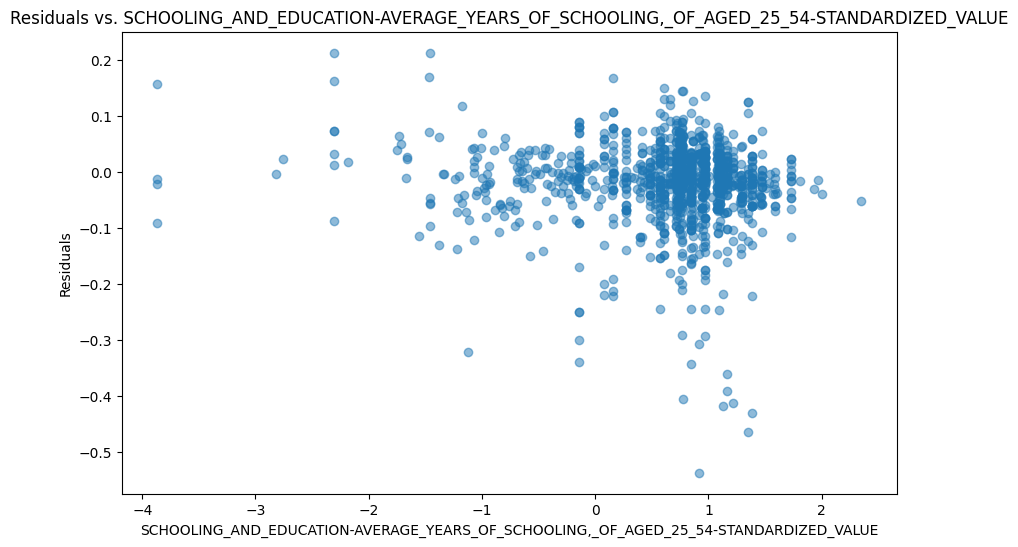

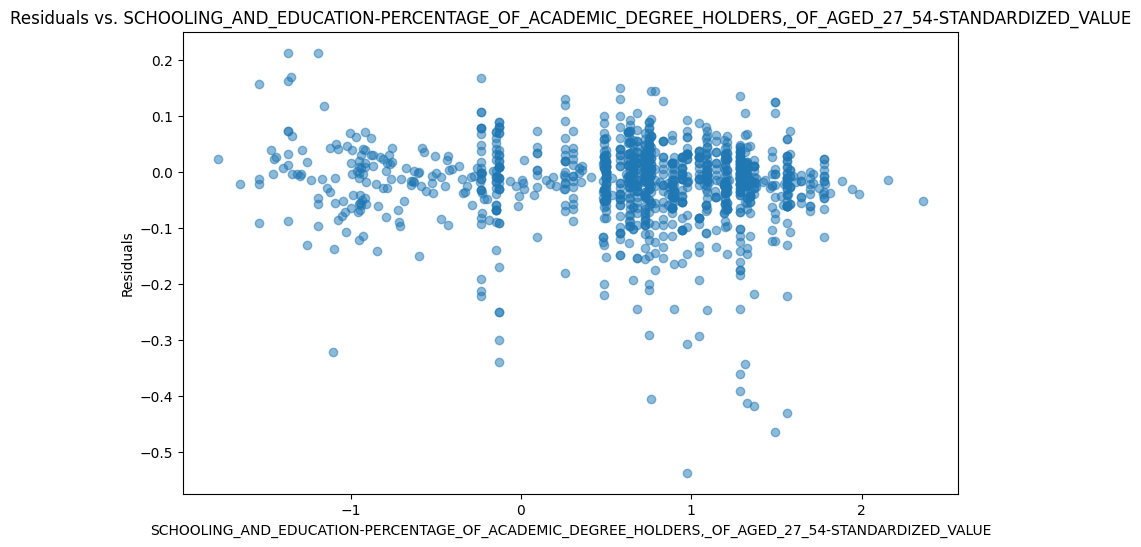

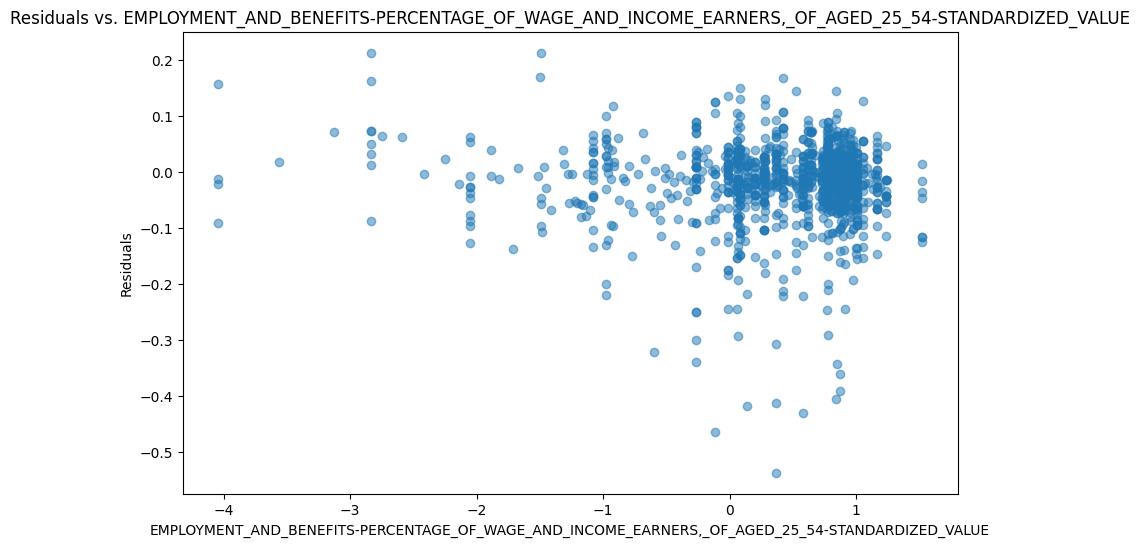

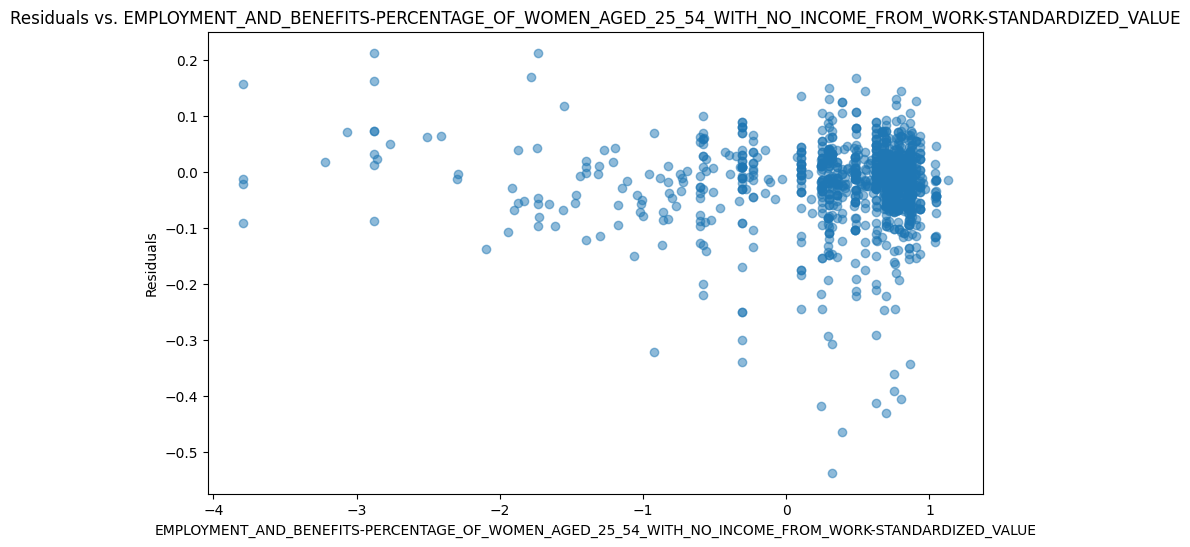

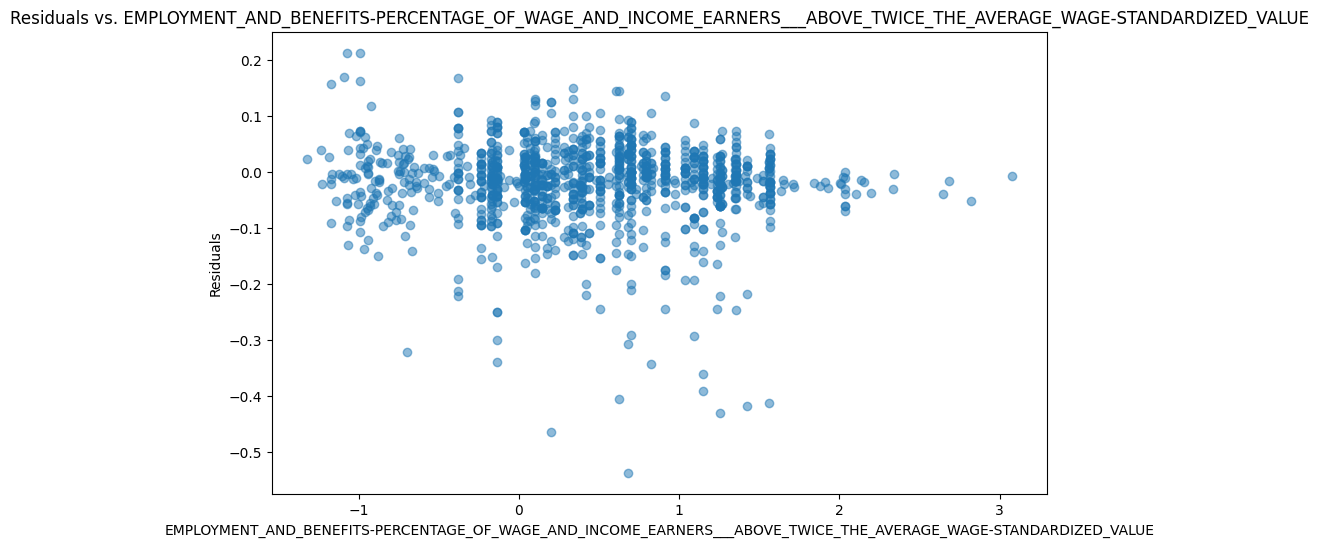

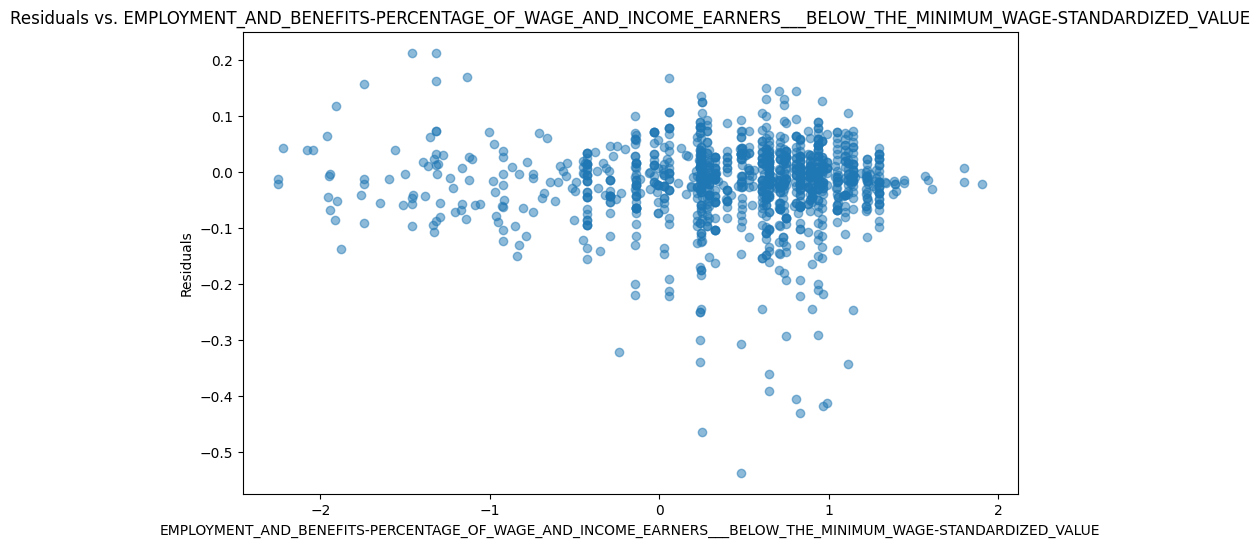

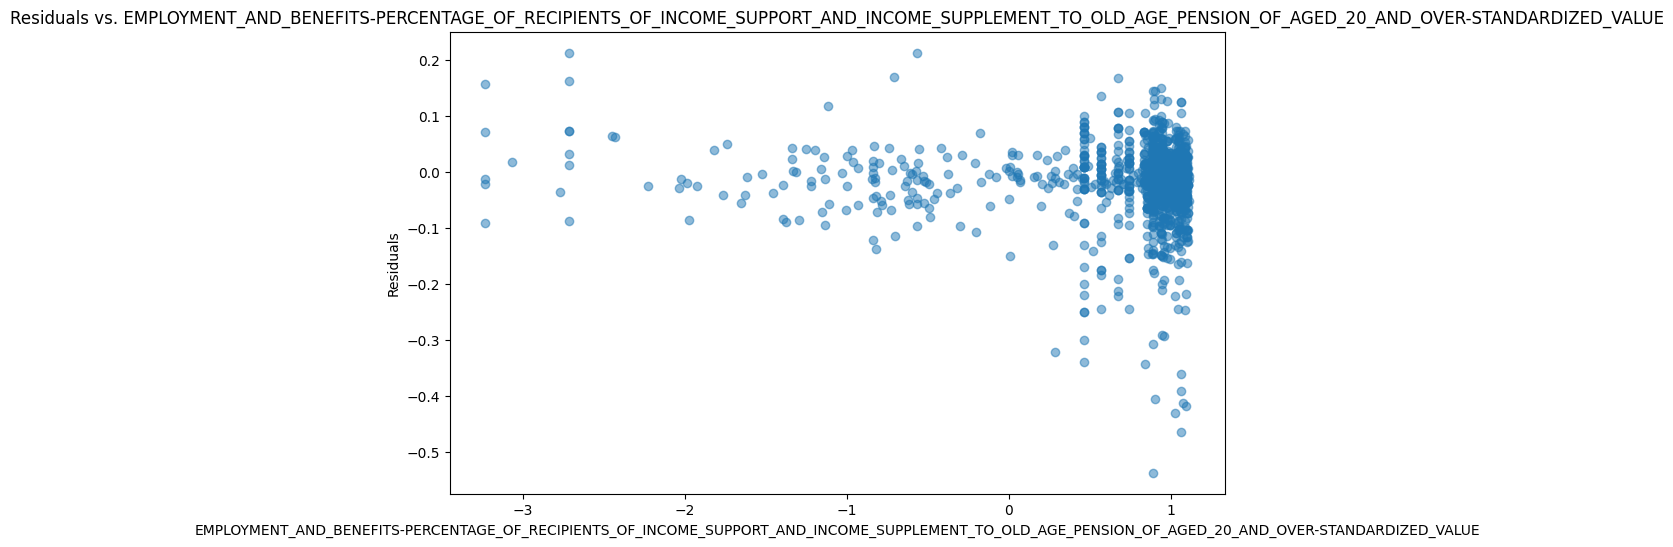

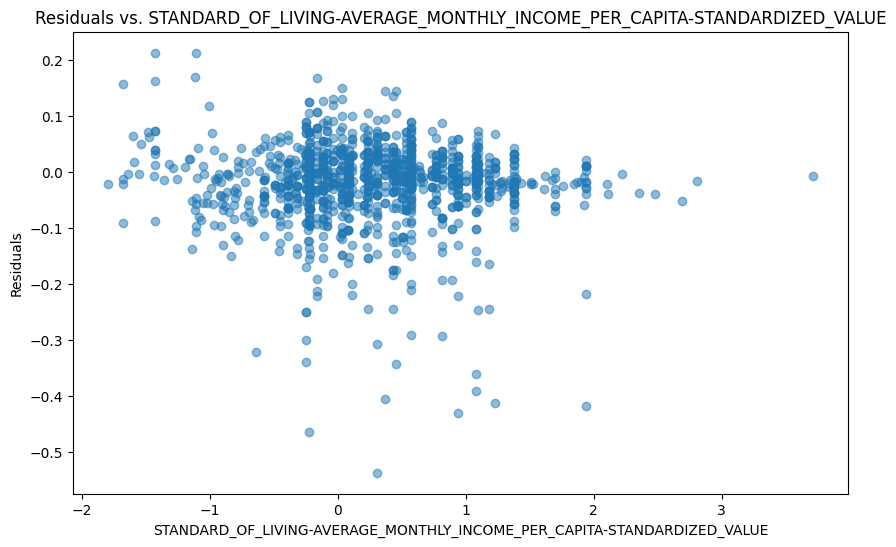

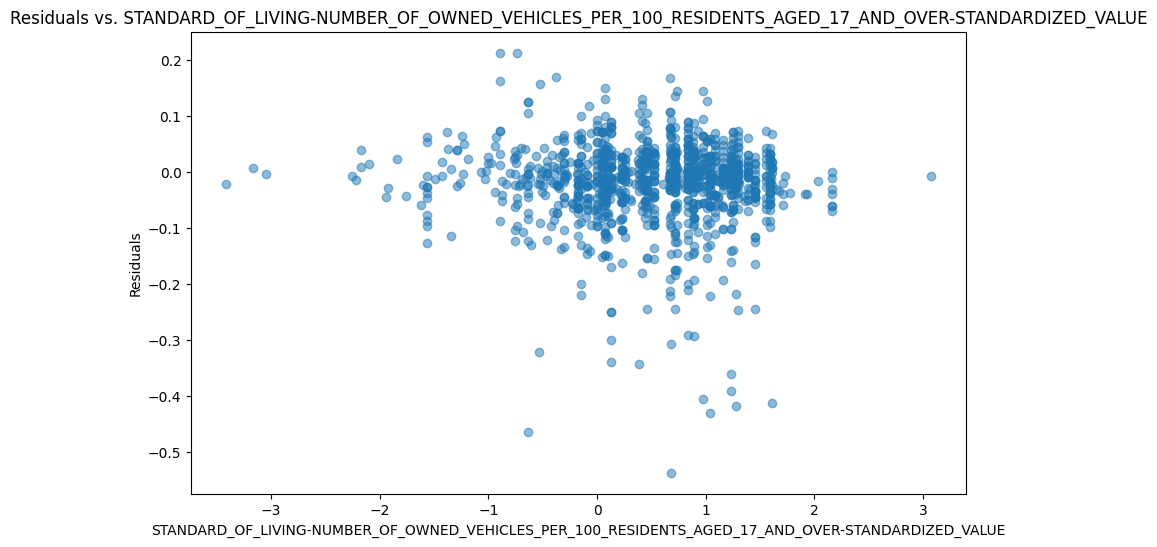

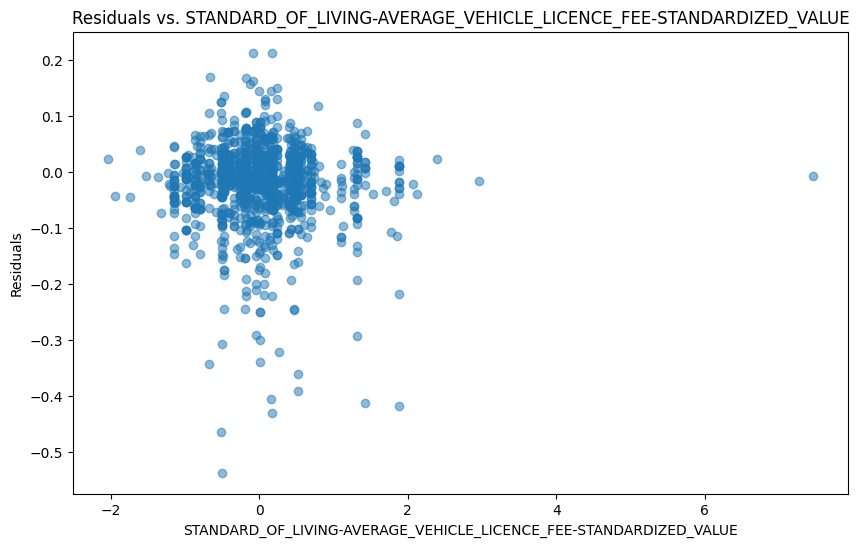

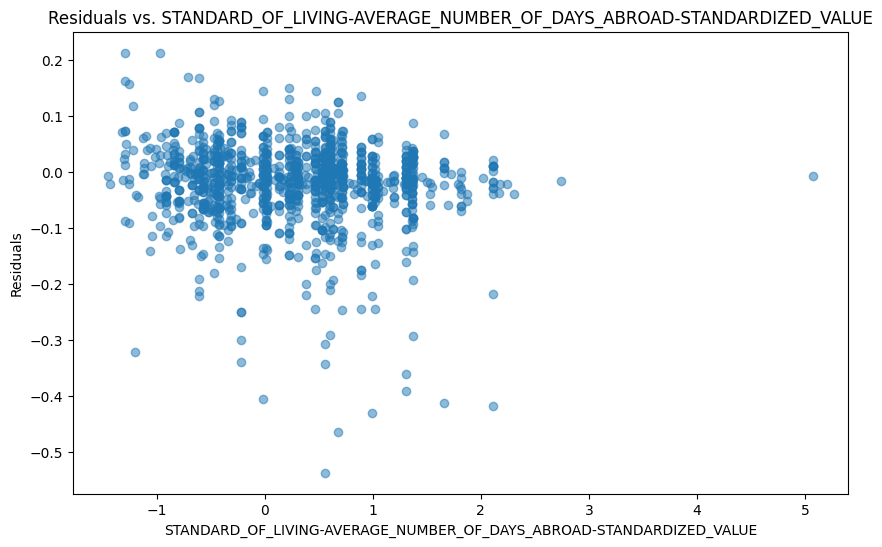

Shapiro-Wilk Test: Statistic=0.8665970790904386, p-value=1.591595644234433e-30


In [63]:
# Calculate residuals (errors)
residuals = y_true - y_pred

# 1. Residuals Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# 2. Residuals vs. Predicted Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Voting Percentage')
plt.ylabel('Residuals')
plt.show()

# 3. Residuals vs. Individual Features
# Plot residuals against each feature to check for patterns
for feature in X_rank_test.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(X_rank_test[feature], residuals, alpha=0.5)
    plt.title(f'Residuals vs. {feature}')
    plt.xlabel(feature)
    plt.ylabel('Residuals')
    plt.show()

# 4. Statistical Tests (if needed)
# Perform statistical tests (e.g., Shapiro-Wilk test for normality) on residuals if you want to formally assess their distribution.
statistic, p_value = shapiro(residuals)
print(f"Shapiro-Wilk Test: Statistic={statistic}, p-value={p_value}")
